In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
import itertools

In [3]:
from ast import literal_eval

### Linear probes eval

In [4]:
resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsp:
    for depth in range(1,5):
        folder_name = "../linprob_sweep/logs/" + key + '/vit_base_patch16/lin_' + str(depth) +'/'

        for root, dirs, files in os.walk(folder_name):
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)      
            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file): 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        resultsp[key][depth] = df

../linprob_sweep/logs/MAE/vit_base_patch16/lin_1/26795/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_2/26796/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_3/26797/log.txt
../linprob_sweep/logs/MAE/vit_base_patch16/lin_4/26798/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_1/26872/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_2/26873/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_3/26874/log.txt
../linprob_sweep/logs/MoCo/vit_base_patch16/lin_4/26875/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_1/26895/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_2/26896/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_3/26897/log.txt
../linprob_sweep/logs/DINO/vit_base_patch16/lin_4/26898/log.txt


In [5]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col, crop=None):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    style = ['solid', 'dashed', 'dashdot', 'dotted']
    colors = ['b', 'r', 'g']
    cc = itertools.cycle(colors)
    
    c = next(cc)
    for i in range(1,5):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, ls=style[i-1], color=c, label=name1)
        
    c = next(cc)
    for i in range(1, 5):
        sns.lineplot(x='epoch', y=col, data = df2[i], ax = ax, ls=style[i-1], color=c, label=name2)
        
    c = next(cc)
    for i in range(1, 5):
        sns.lineplot(x='epoch', y=col, data = df3[i], ax = ax, ls=style[i-1], color=c, label=name3)
        
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    plt.xlim([0, 90])

    if crop == 'f20':
        plt.xlim([0, 20])
        plt.ylim([0, 80]) if col=='test_acc1' else plt.ylim([0, 90])
    elif crop == 'l70':
        plt.xlim([20, 90])
        plt.ylim([60, 80]) if col=='test_acc1' else plt.ylim([80, 100])
    
    ax.set_xlabel("Linear Probe Training Epochs")
    ax.set_ylabel("Top-5 ImageNet accuracy") if col=='test_acc5' else ax.set_ylabel("Top-1 ImageNet accuracy")

    
    print(len(ax.lines))
    #ax.legend(title='Pre-training algorithm', loc='lower center')#, labels=[name1, name2, name3])
    legend1 = plt.legend([ax.lines[0], ax.lines[4], ax.lines[8]], [name1, name2, name3], title='Pre-training algorithm', loc=4)
    plt.legend([ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3]], ['1', '2', '3', '4'], title='Probe depth', loc=8)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.show()

    if crop == None:
        crop = ''
    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'-'+col+crop+'.png')

    return fig

In [ ]:
fig_dir = '../figures/linprobe/'

prod = itertools.combinations(resultsp.keys(), 3)

for name1, name2, name3 in prod:

    for col in ["test_acc1", "test_acc5"]:
        for crop in [None, 'f20', 'l70']:
            full_fig_dir = fig_dir + col + '/'
            fig = dynamics_plot_single(full_fig_dir, resultsp[name1], resultsp[name2], resultsp[name3], name1, name2, name3, col=col)

In [118]:
df= {}
for key in resultsp:
    df[key] = {}
    for depth in range(1,5):
        print(key, depth)
        df[key][depth] = {}
        print(resultsp[key][depth]['test_acc1'].max(), resultsp[key][depth]['test_acc5'].max())
        df[key][depth] = resultsp[key][depth]['test_acc1'].max()

MAE 1
67.69600000991821 87.48000002380371
MAE 2
68.13800000823974 88.05800002929688
MAE 3
68.72800000839233 88.48800002929687
MAE 4
68.4320000074768 88.40199999206543
MoCo 1
76.24200002227784 93.22600004211425
MoCo 2
76.086000027771 93.05400001800537
MoCo 3
75.83599999481201 92.89800000732421
MoCo 4
75.58400002105712 92.63800002075196
DINO 1
77.82200001922608 93.81600002929687
DINO 2
77.74200003784179 93.77800002380371
DINO 3
77.39600003570557 93.66600003479004
DINO 4
77.01800002258301 93.37800003753662


In [57]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe Depth'}, inplace=True)
df = df.melt(id_vars=['Probe Depth'], value_name='Top-1', var_name='Model')

In [58]:
df['Top-1 relative'] = df['Top 1'] - (df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0])

Probe Depth Model   Top-1
0             1   MAE  67.696
1             2   MAE  68.138
2             3   MAE  68.728
3             4   MAE  68.432
4             1  MoCo  76.242
5             2  MoCo  76.086
6             3  MoCo  75.836
7             4  MoCo  75.584
8             1  DINO  77.822
9             2  DINO  77.742
10            3  DINO  77.396
11            4  DINO  77.018

In [116]:
fig_dir = '../figures/ICML/'

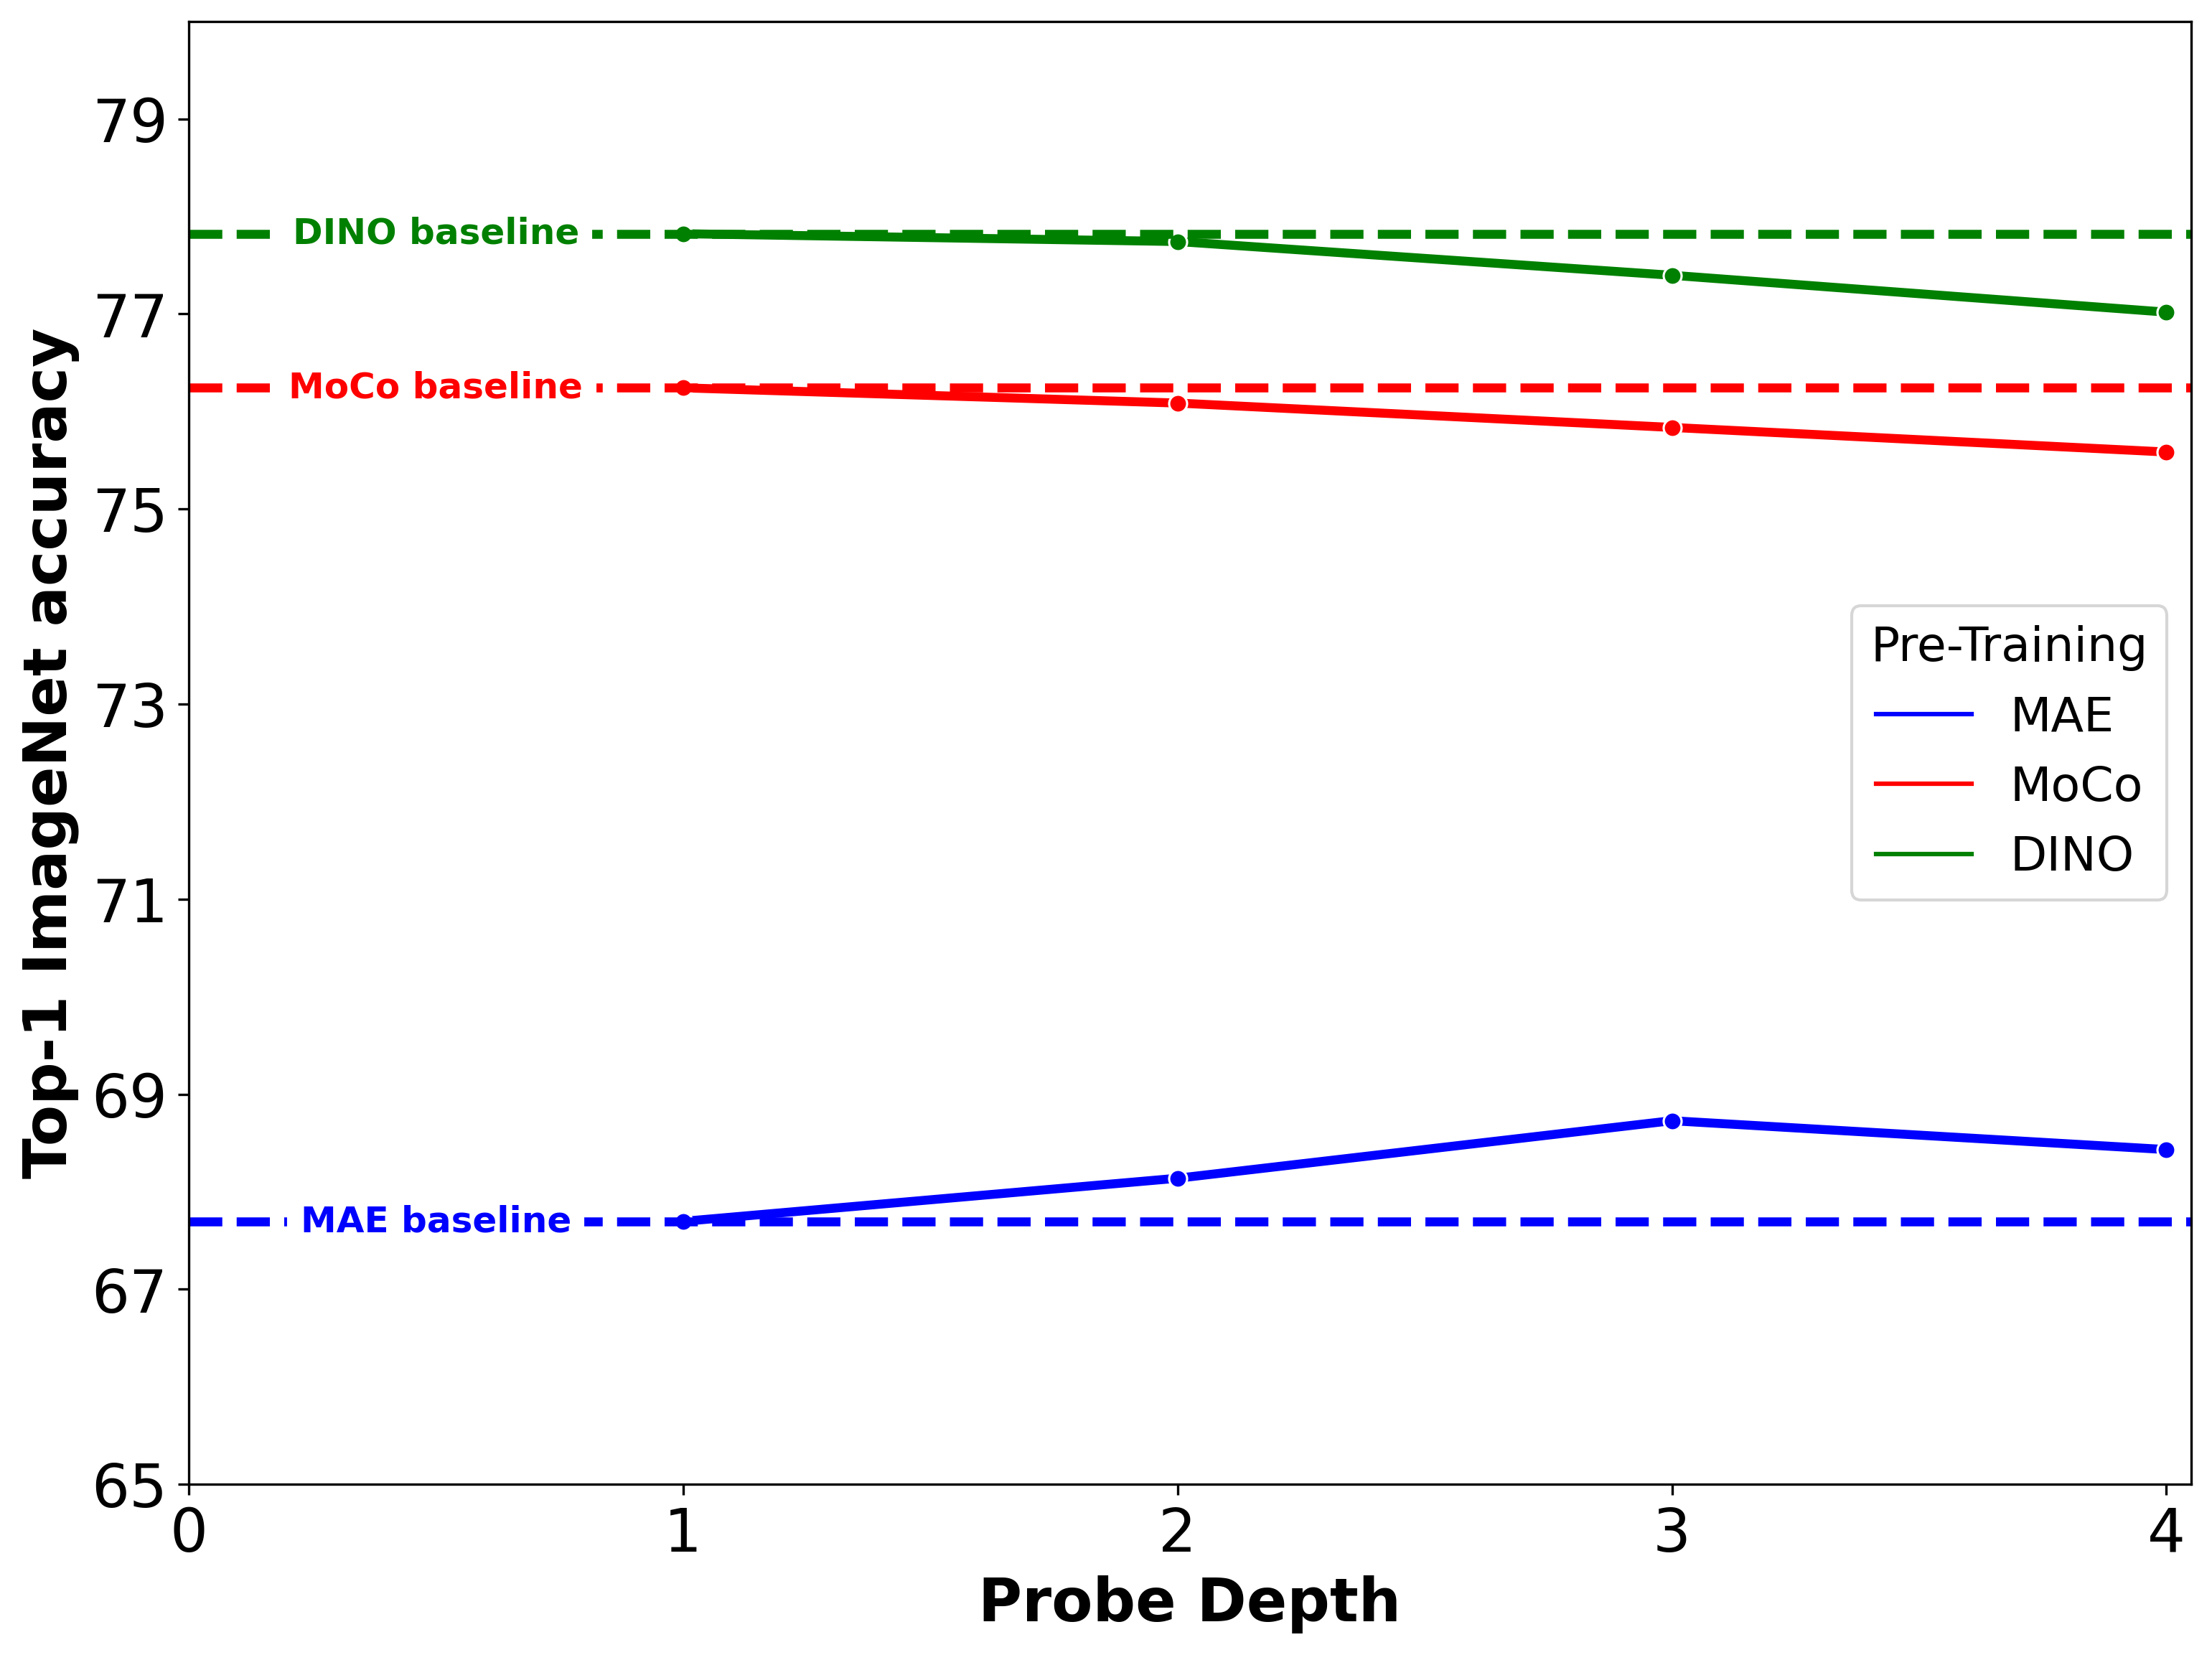

In [117]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

sns.lineplot(data=df, x='Probe Depth', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')

ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.xlim([0, 4.05])
plt.ylim([65, 80])

ax.set_xticks(np.arange(0, 5, 1), visible=True)
ax.set_yticks(np.arange(65, 80, 2), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(65, 80, 2)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16})
plt.setp(legend.get_title(),fontsize=16)

fig.savefig(fig_dir + 'deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Attention probes eval

In [7]:
resultsa = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsa:
    for depth in range(1,5):
        folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/" + key + '/vit_base_patch16/vit_' + str(depth) +'/'

        for root, dirs, files in os.walk(folder_name):
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)      
            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file): 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        resultsa[key][depth] = df

/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MAE/vit_base_patch16/vit_1/847565/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MAE/vit_base_patch16/vit_2/847566/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MAE/vit_base_patch16/vit_3/847567/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MAE/vit_base_patch16/vit_4/847568/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MoCo/vit_base_patch16/vit_1/847707/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MoCo/vit_base_patch16/vit_2/847708/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MoCo/vit_base_patch16/vit_3/847709/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/MoCo/vit_base_patch16/vit_4/847710/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitprob_sweep/logs/DINO/vit_base_patch16/vit_1/847107/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/vitpro

In [8]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col, crop=None):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    style = ['solid', 'dashed', 'dashdot', 'dotted']
    colors = ['b', 'r', 'g']
    cc = itertools.cycle(colors)
    
    c = next(cc)
    for i in range(1,5):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, ls=style[i-1], color=c, label=name1)
        
    c = next(cc)
    for i in range(1, 5):
        sns.lineplot(x='epoch', y=col, data = df2[i], ax = ax, ls=style[i-1], color=c, label=name2)
        
    c = next(cc)
    for i in range(1, 5):
        sns.lineplot(x='epoch', y=col, data = df3[i], ax = ax, ls=style[i-1], color=c, label=name3)
        
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    plt.xlim([0, 90])

    if crop == 'f20':
        plt.xlim([0, 10])
        plt.ylim([0, 80]) if col=='test_acc1' else plt.ylim([0, 90])
    elif crop == 'l70':
        plt.xlim([20, 90])
        plt.ylim([60, 80]) if col=='test_acc1' else plt.ylim([80, 100])
    
    ax.set_xlabel("Attention Probe Training Epochs")
    ax.set_ylabel("Top-5 ImageNet accuracy") if col=='test_acc5' else ax.set_ylabel("Top-1 ImageNet accuracy")
    
    print(len(ax.lines))
    #ax.legend(title='Pre-training algorithm', loc='lower center')#, labels=[name1, name2, name3])
    legend1 = plt.legend([ax.lines[0], ax.lines[4], ax.lines[8]], [name1, name2, name3], title='Pre-training algorithm', loc=4)
    plt.legend([ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3]], ['1', '2', '3', '4'], title='Attention Probe depth', loc=8)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.show()

    if crop == None:
        crop = ''
    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'-'+col+crop+'.png')

    return fig

In [9]:
import itertools

12


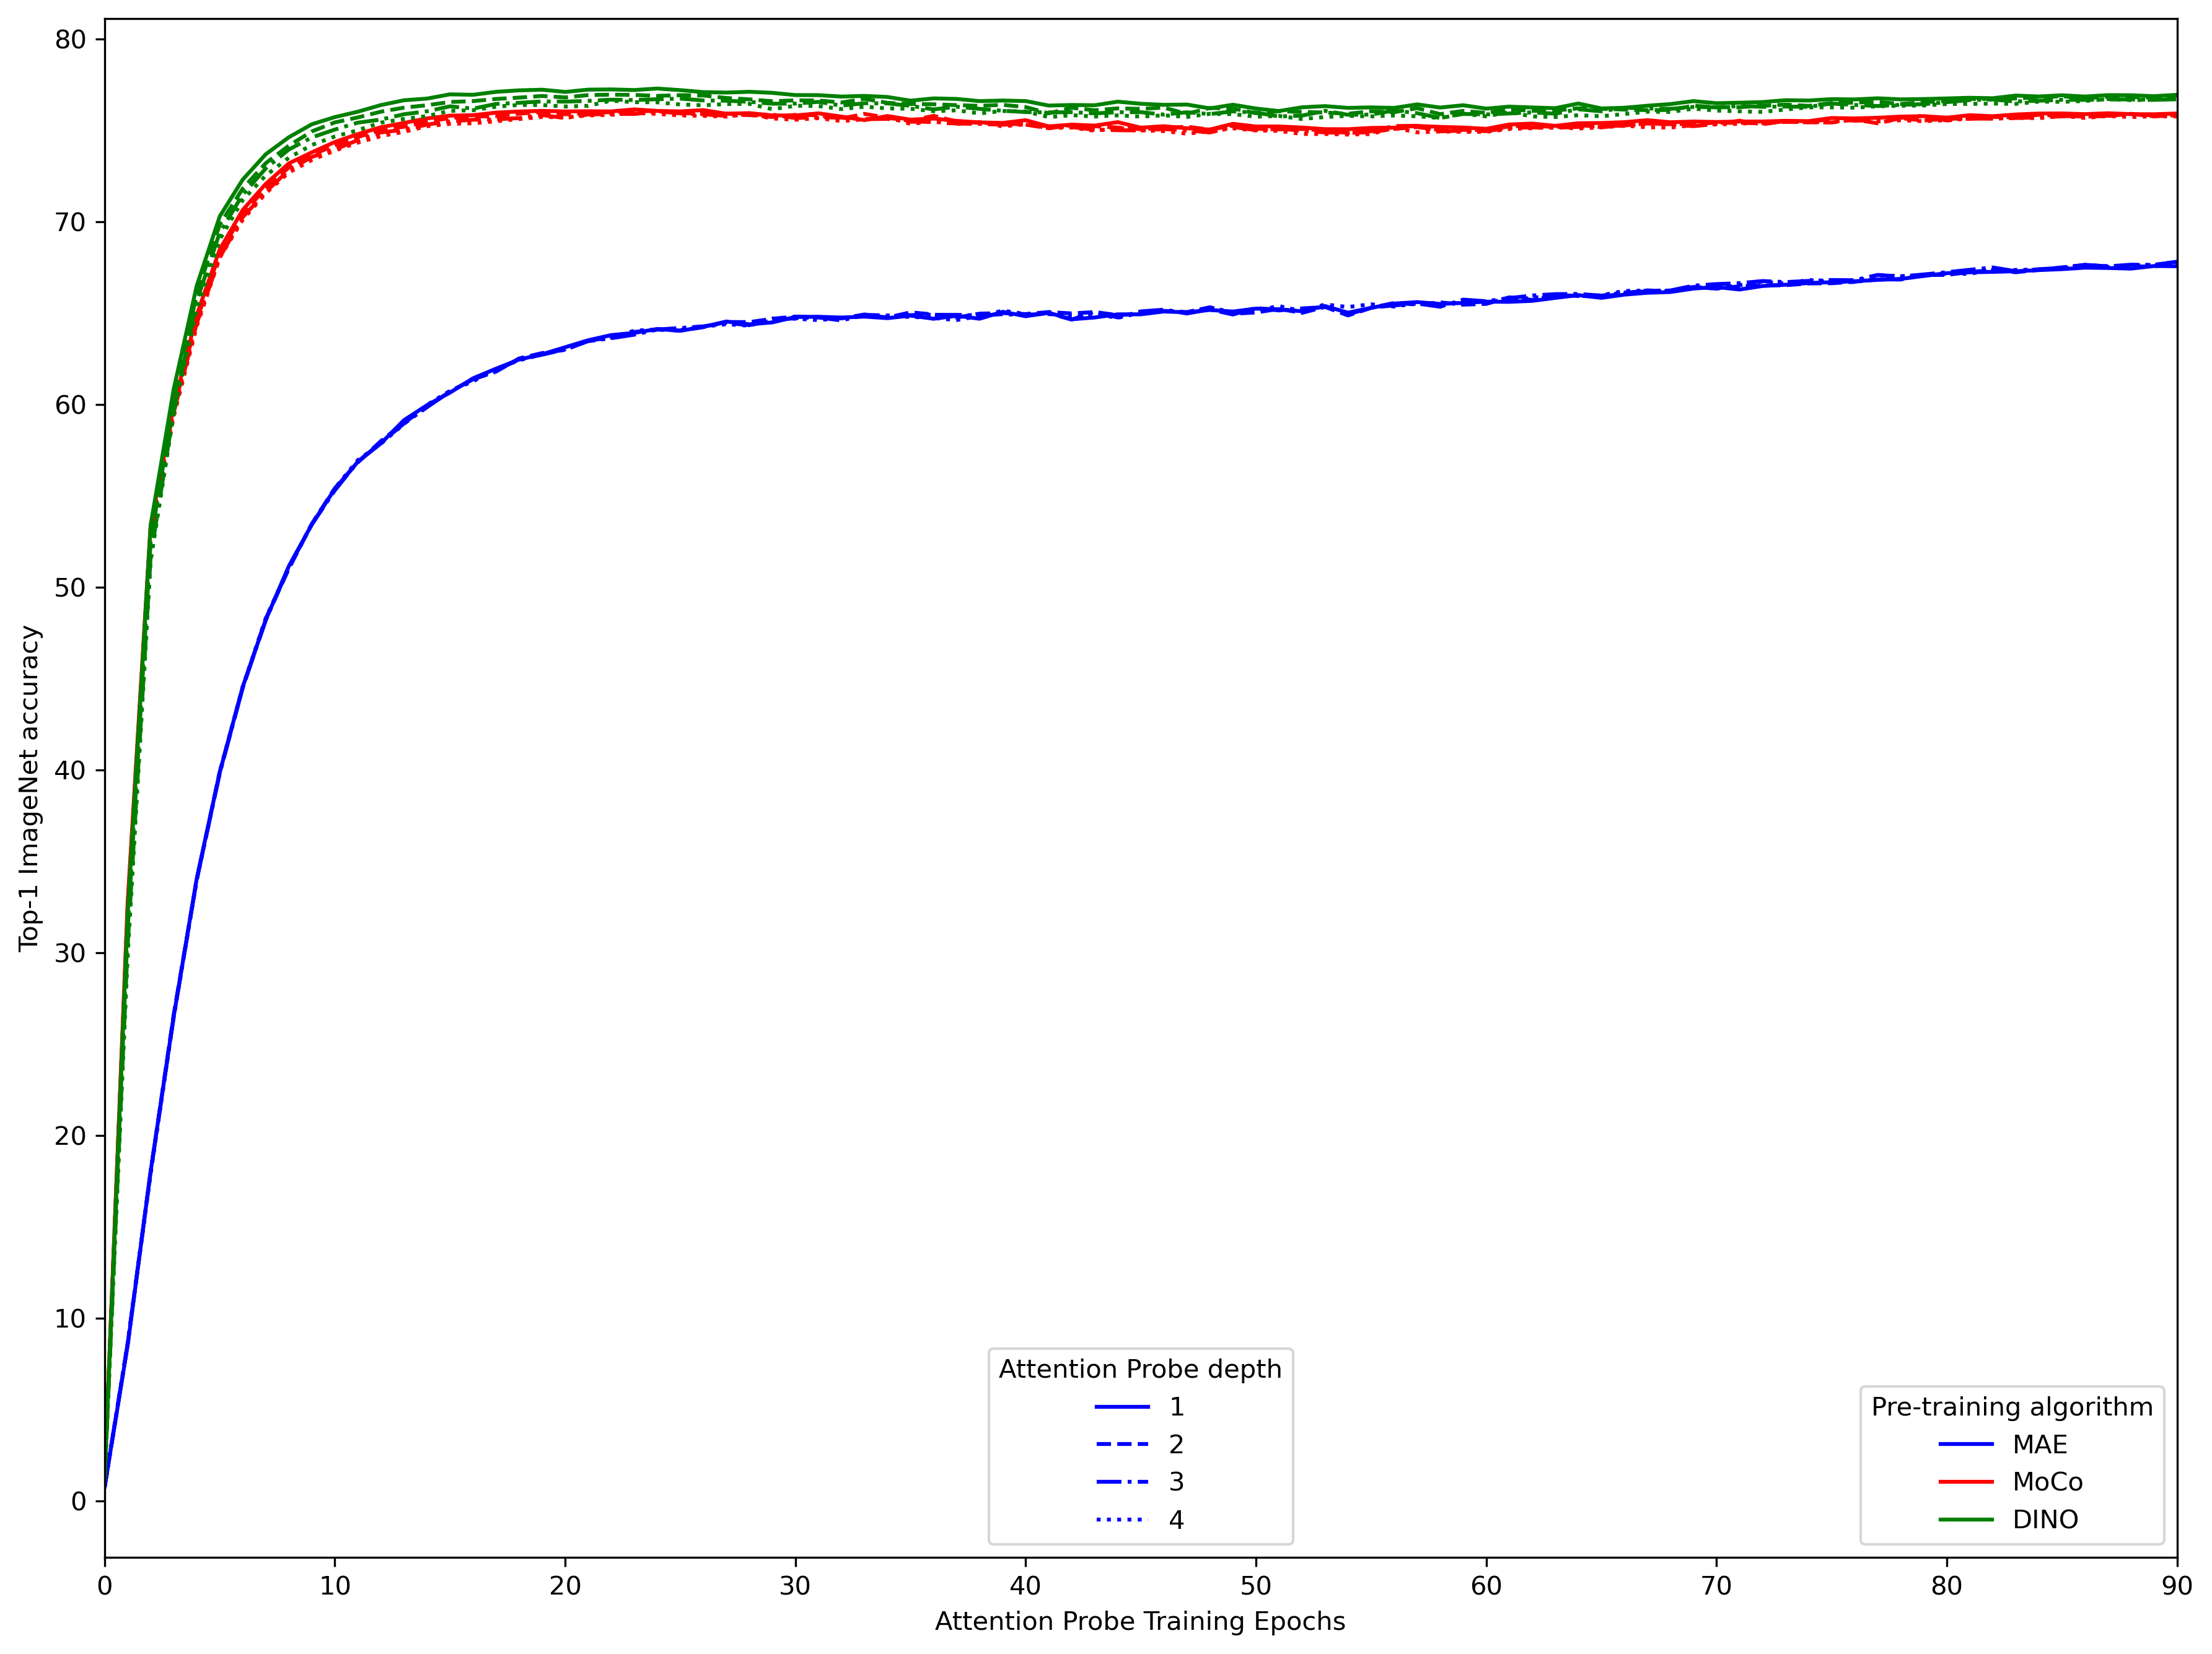

12


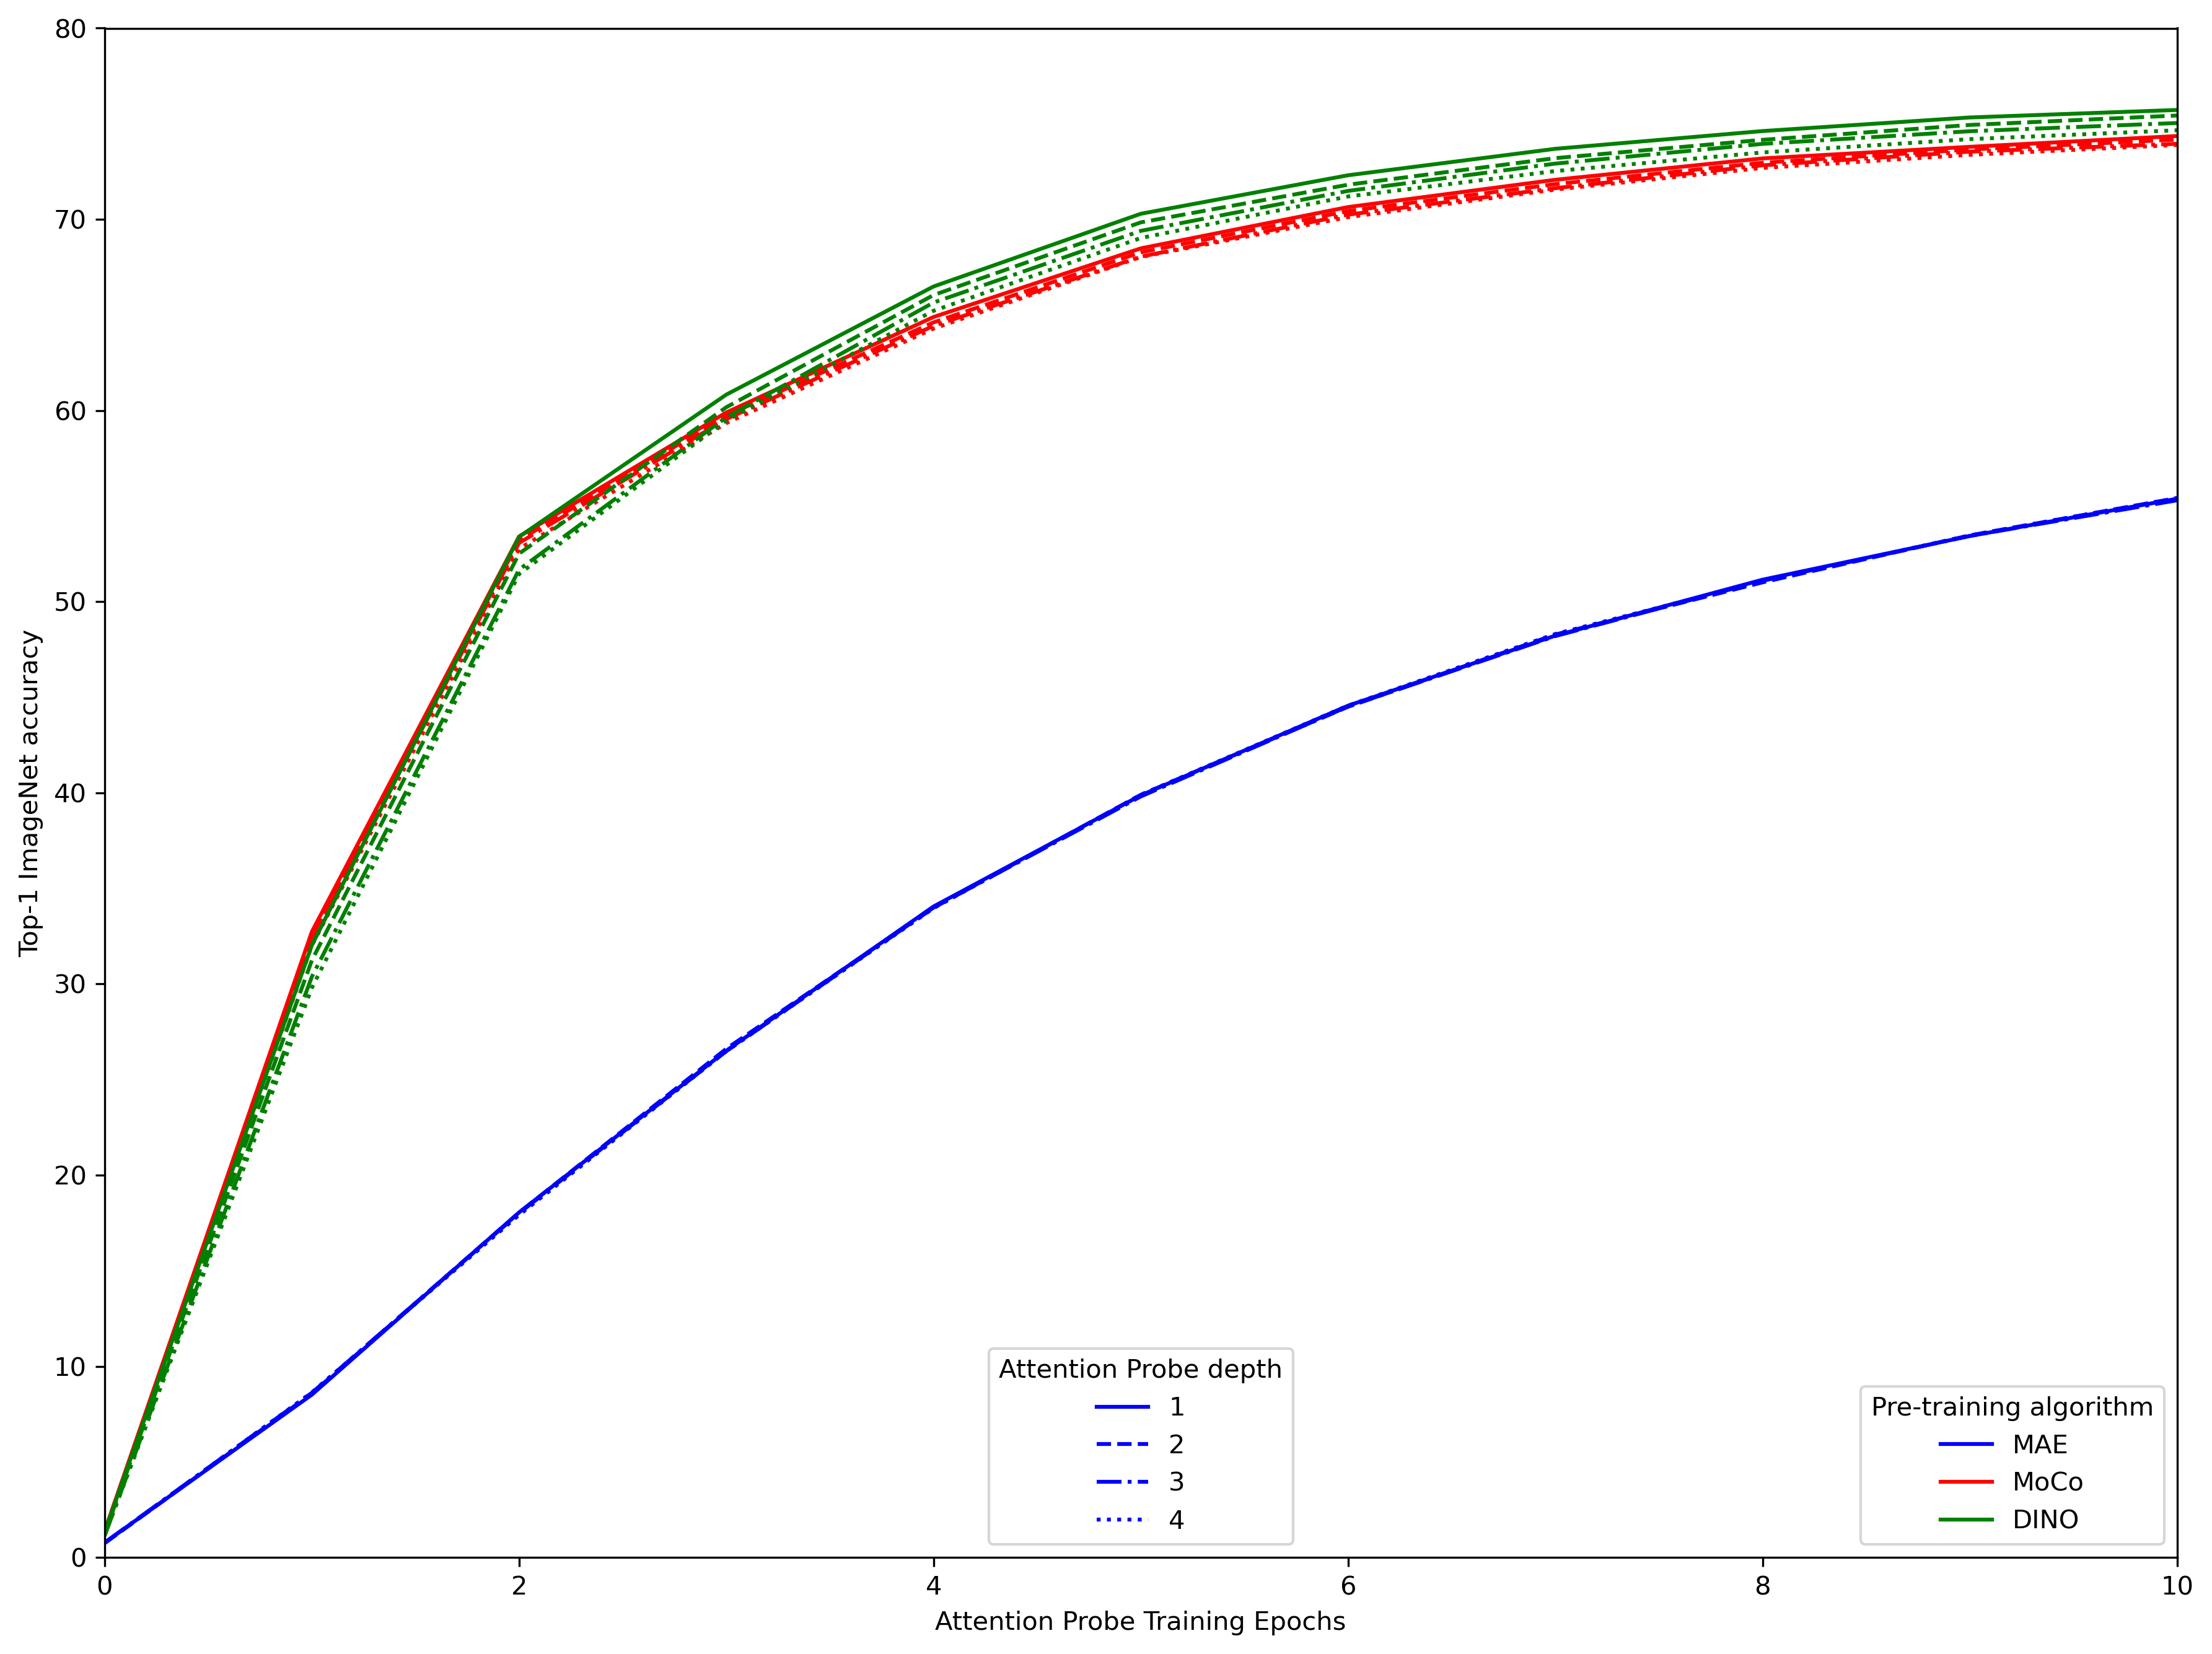

12


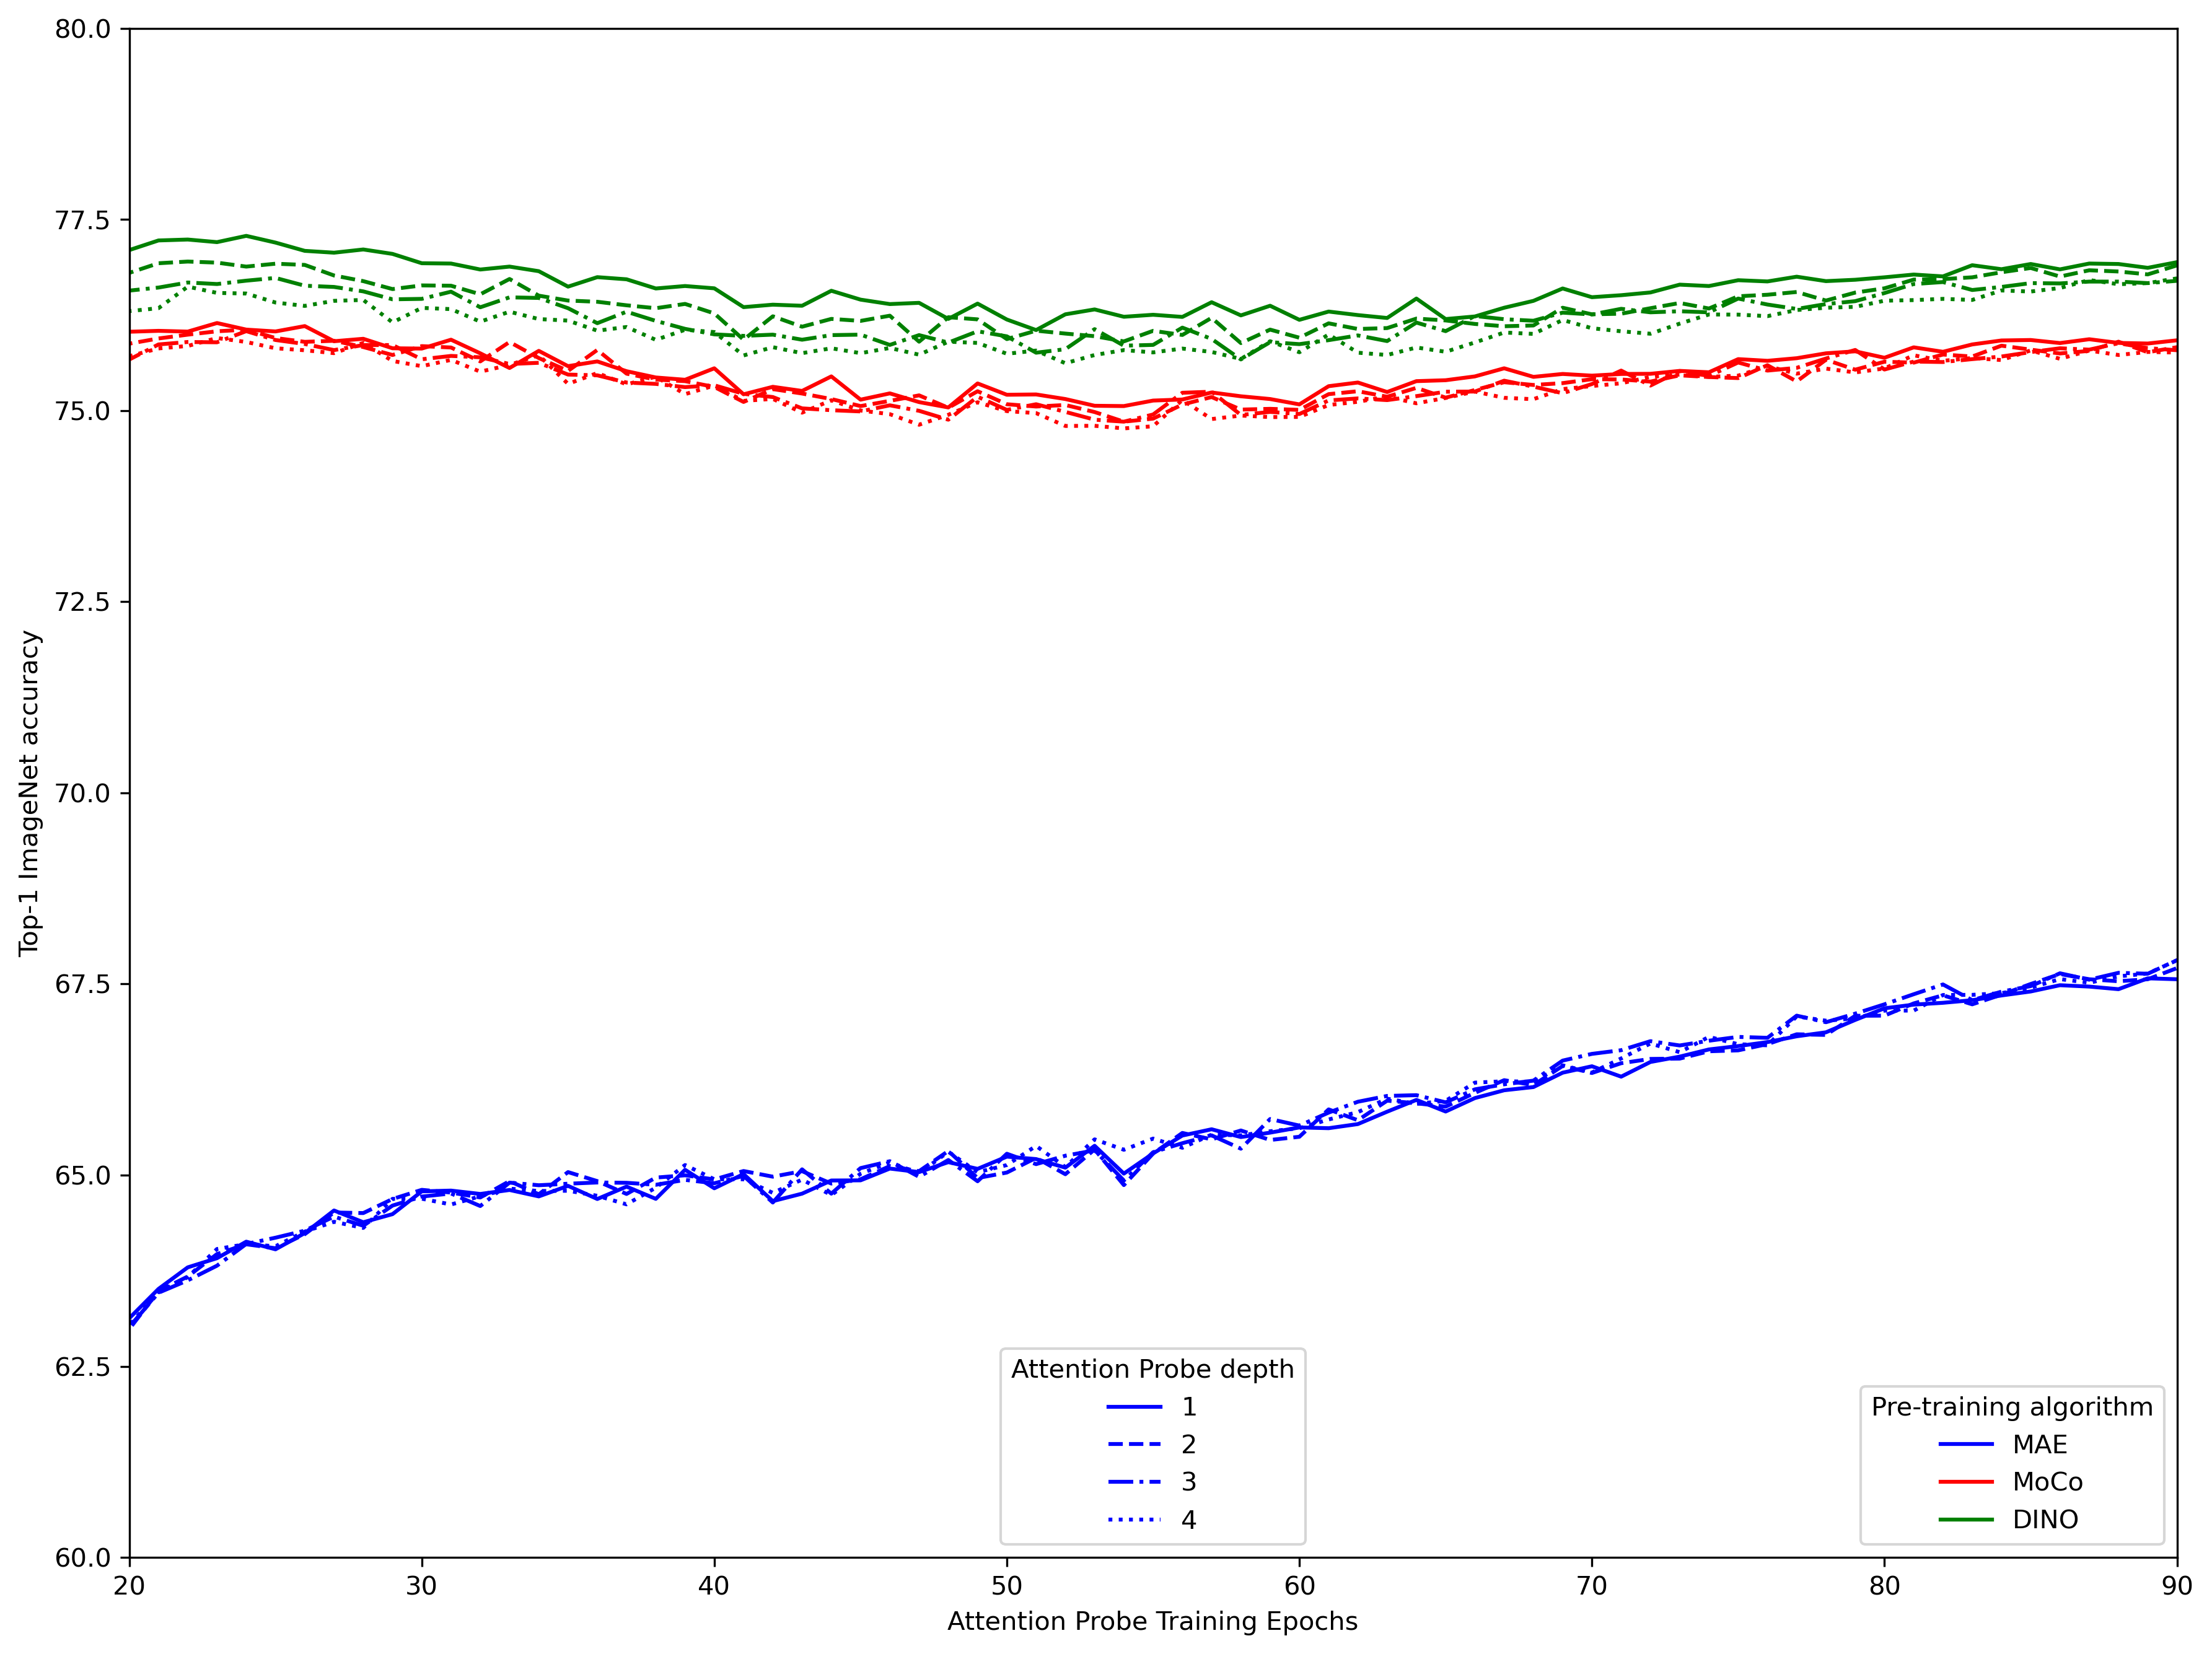

12


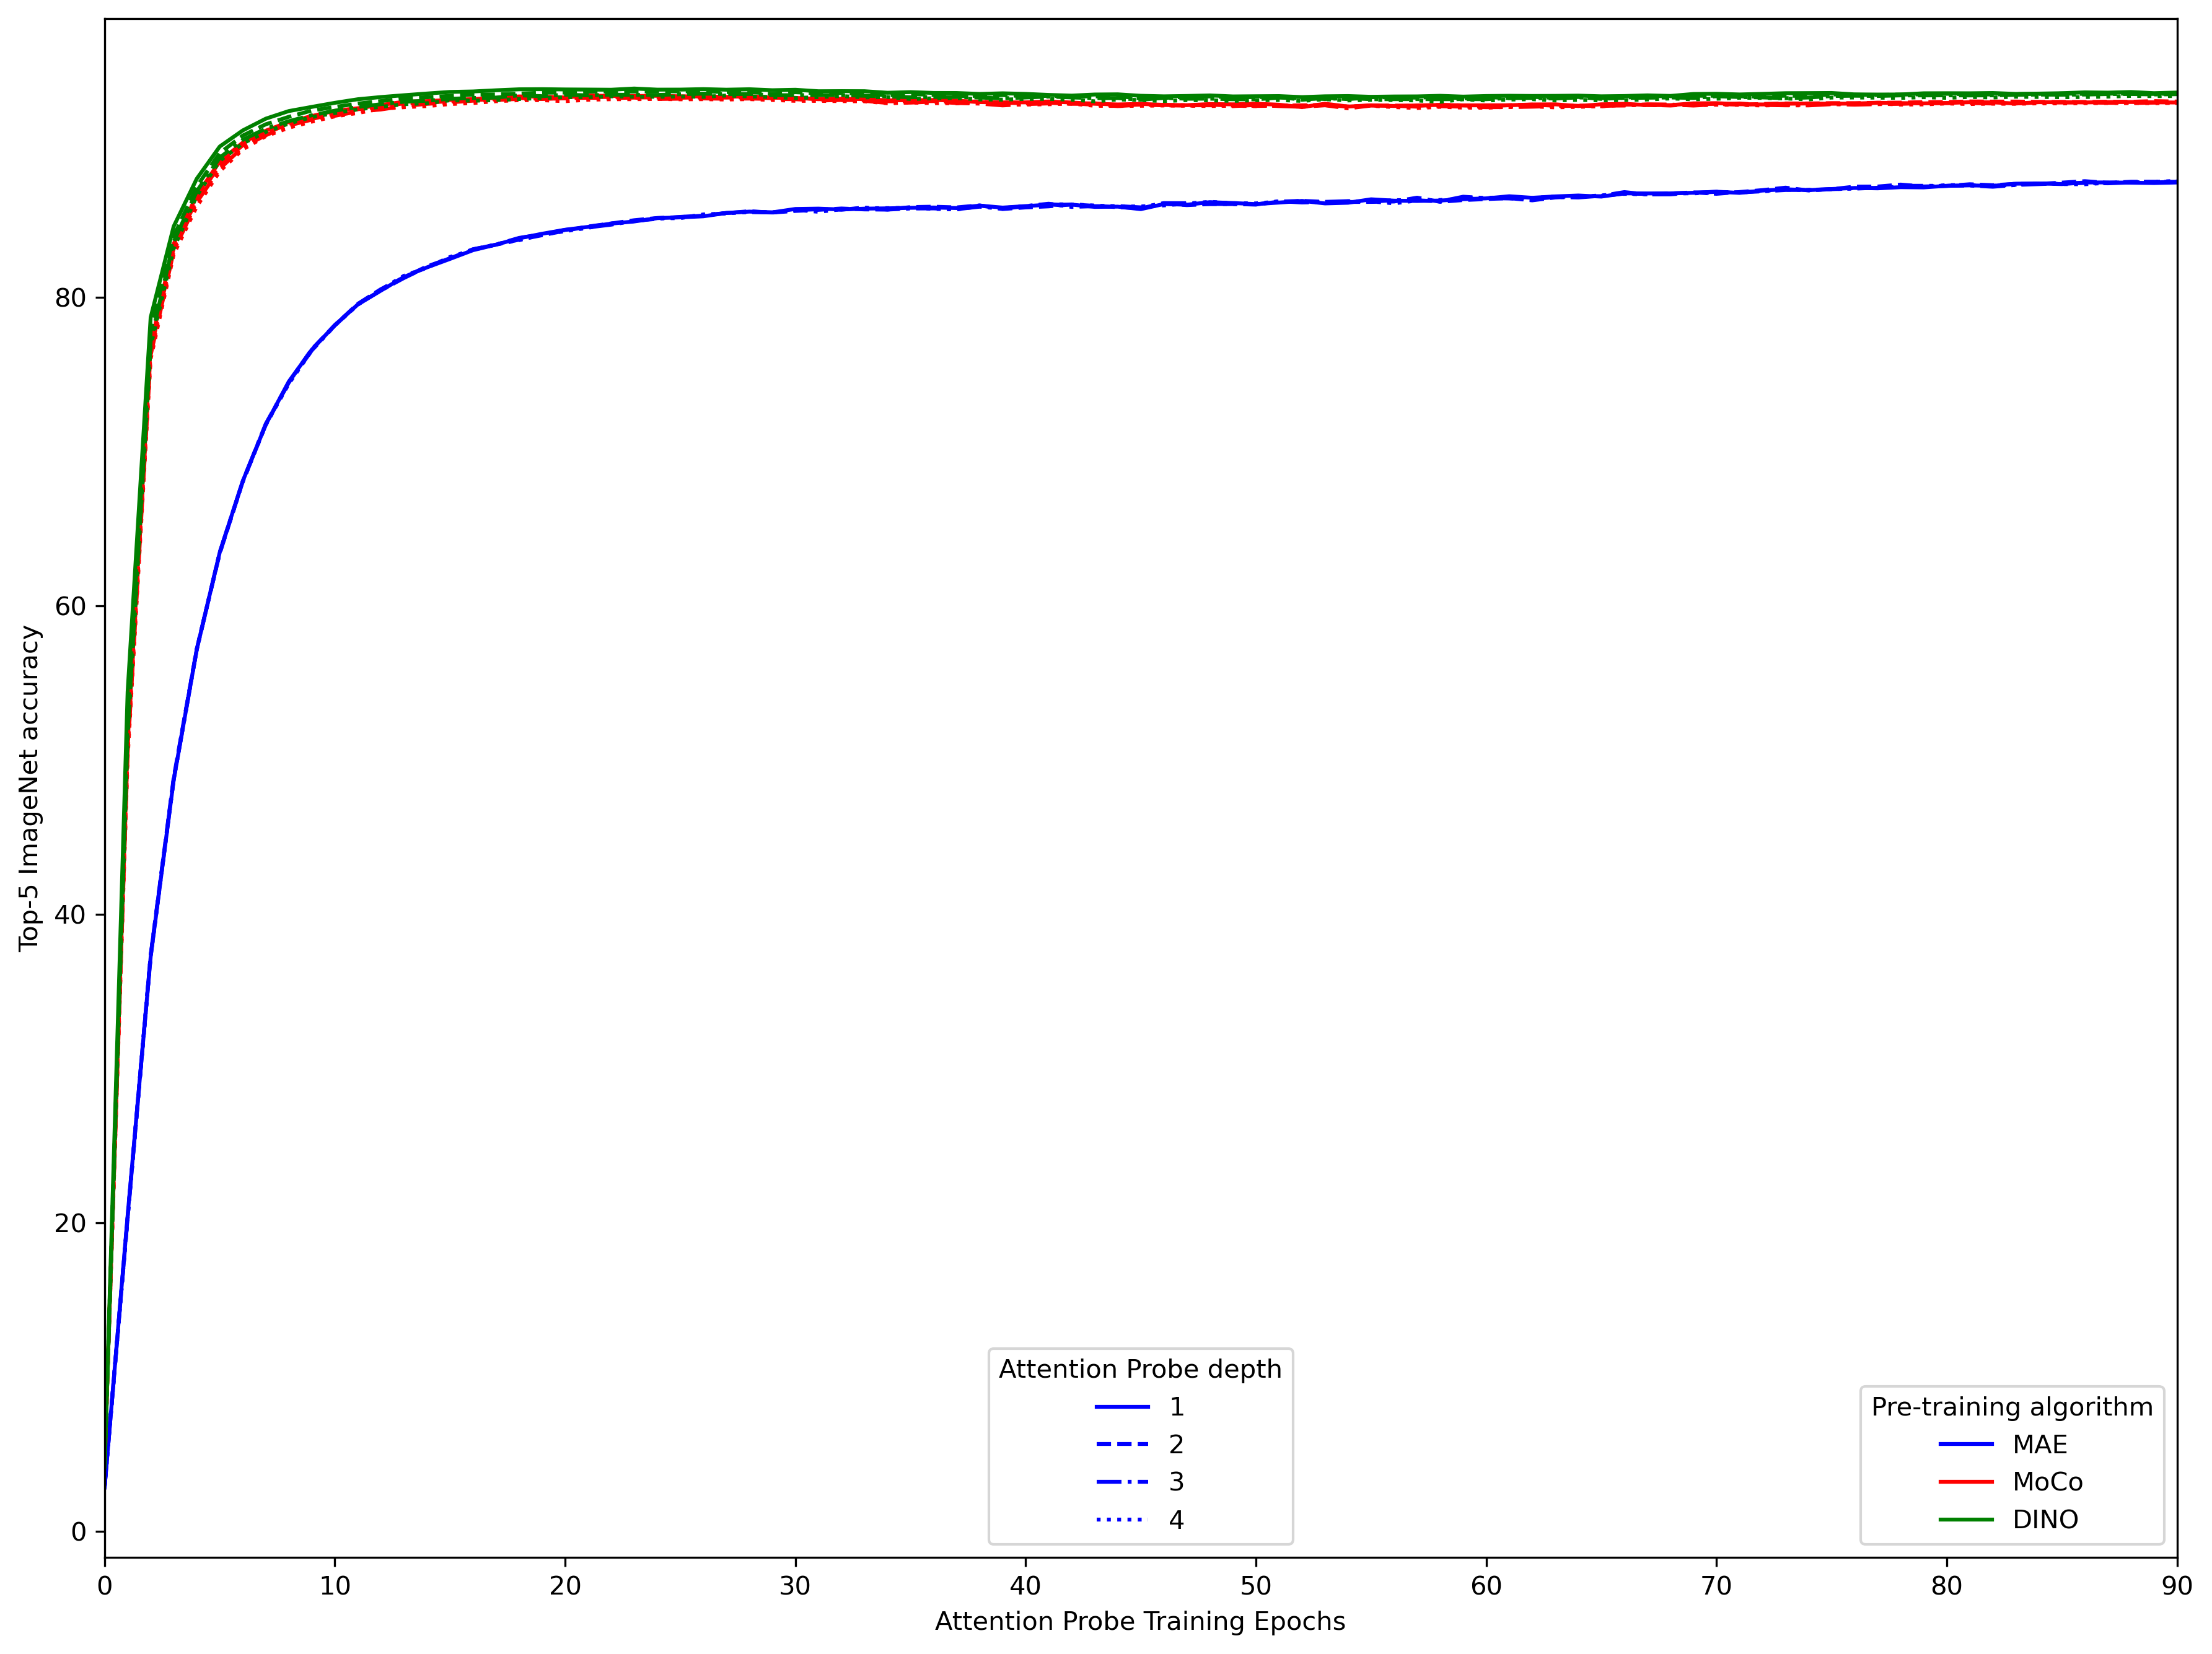

12


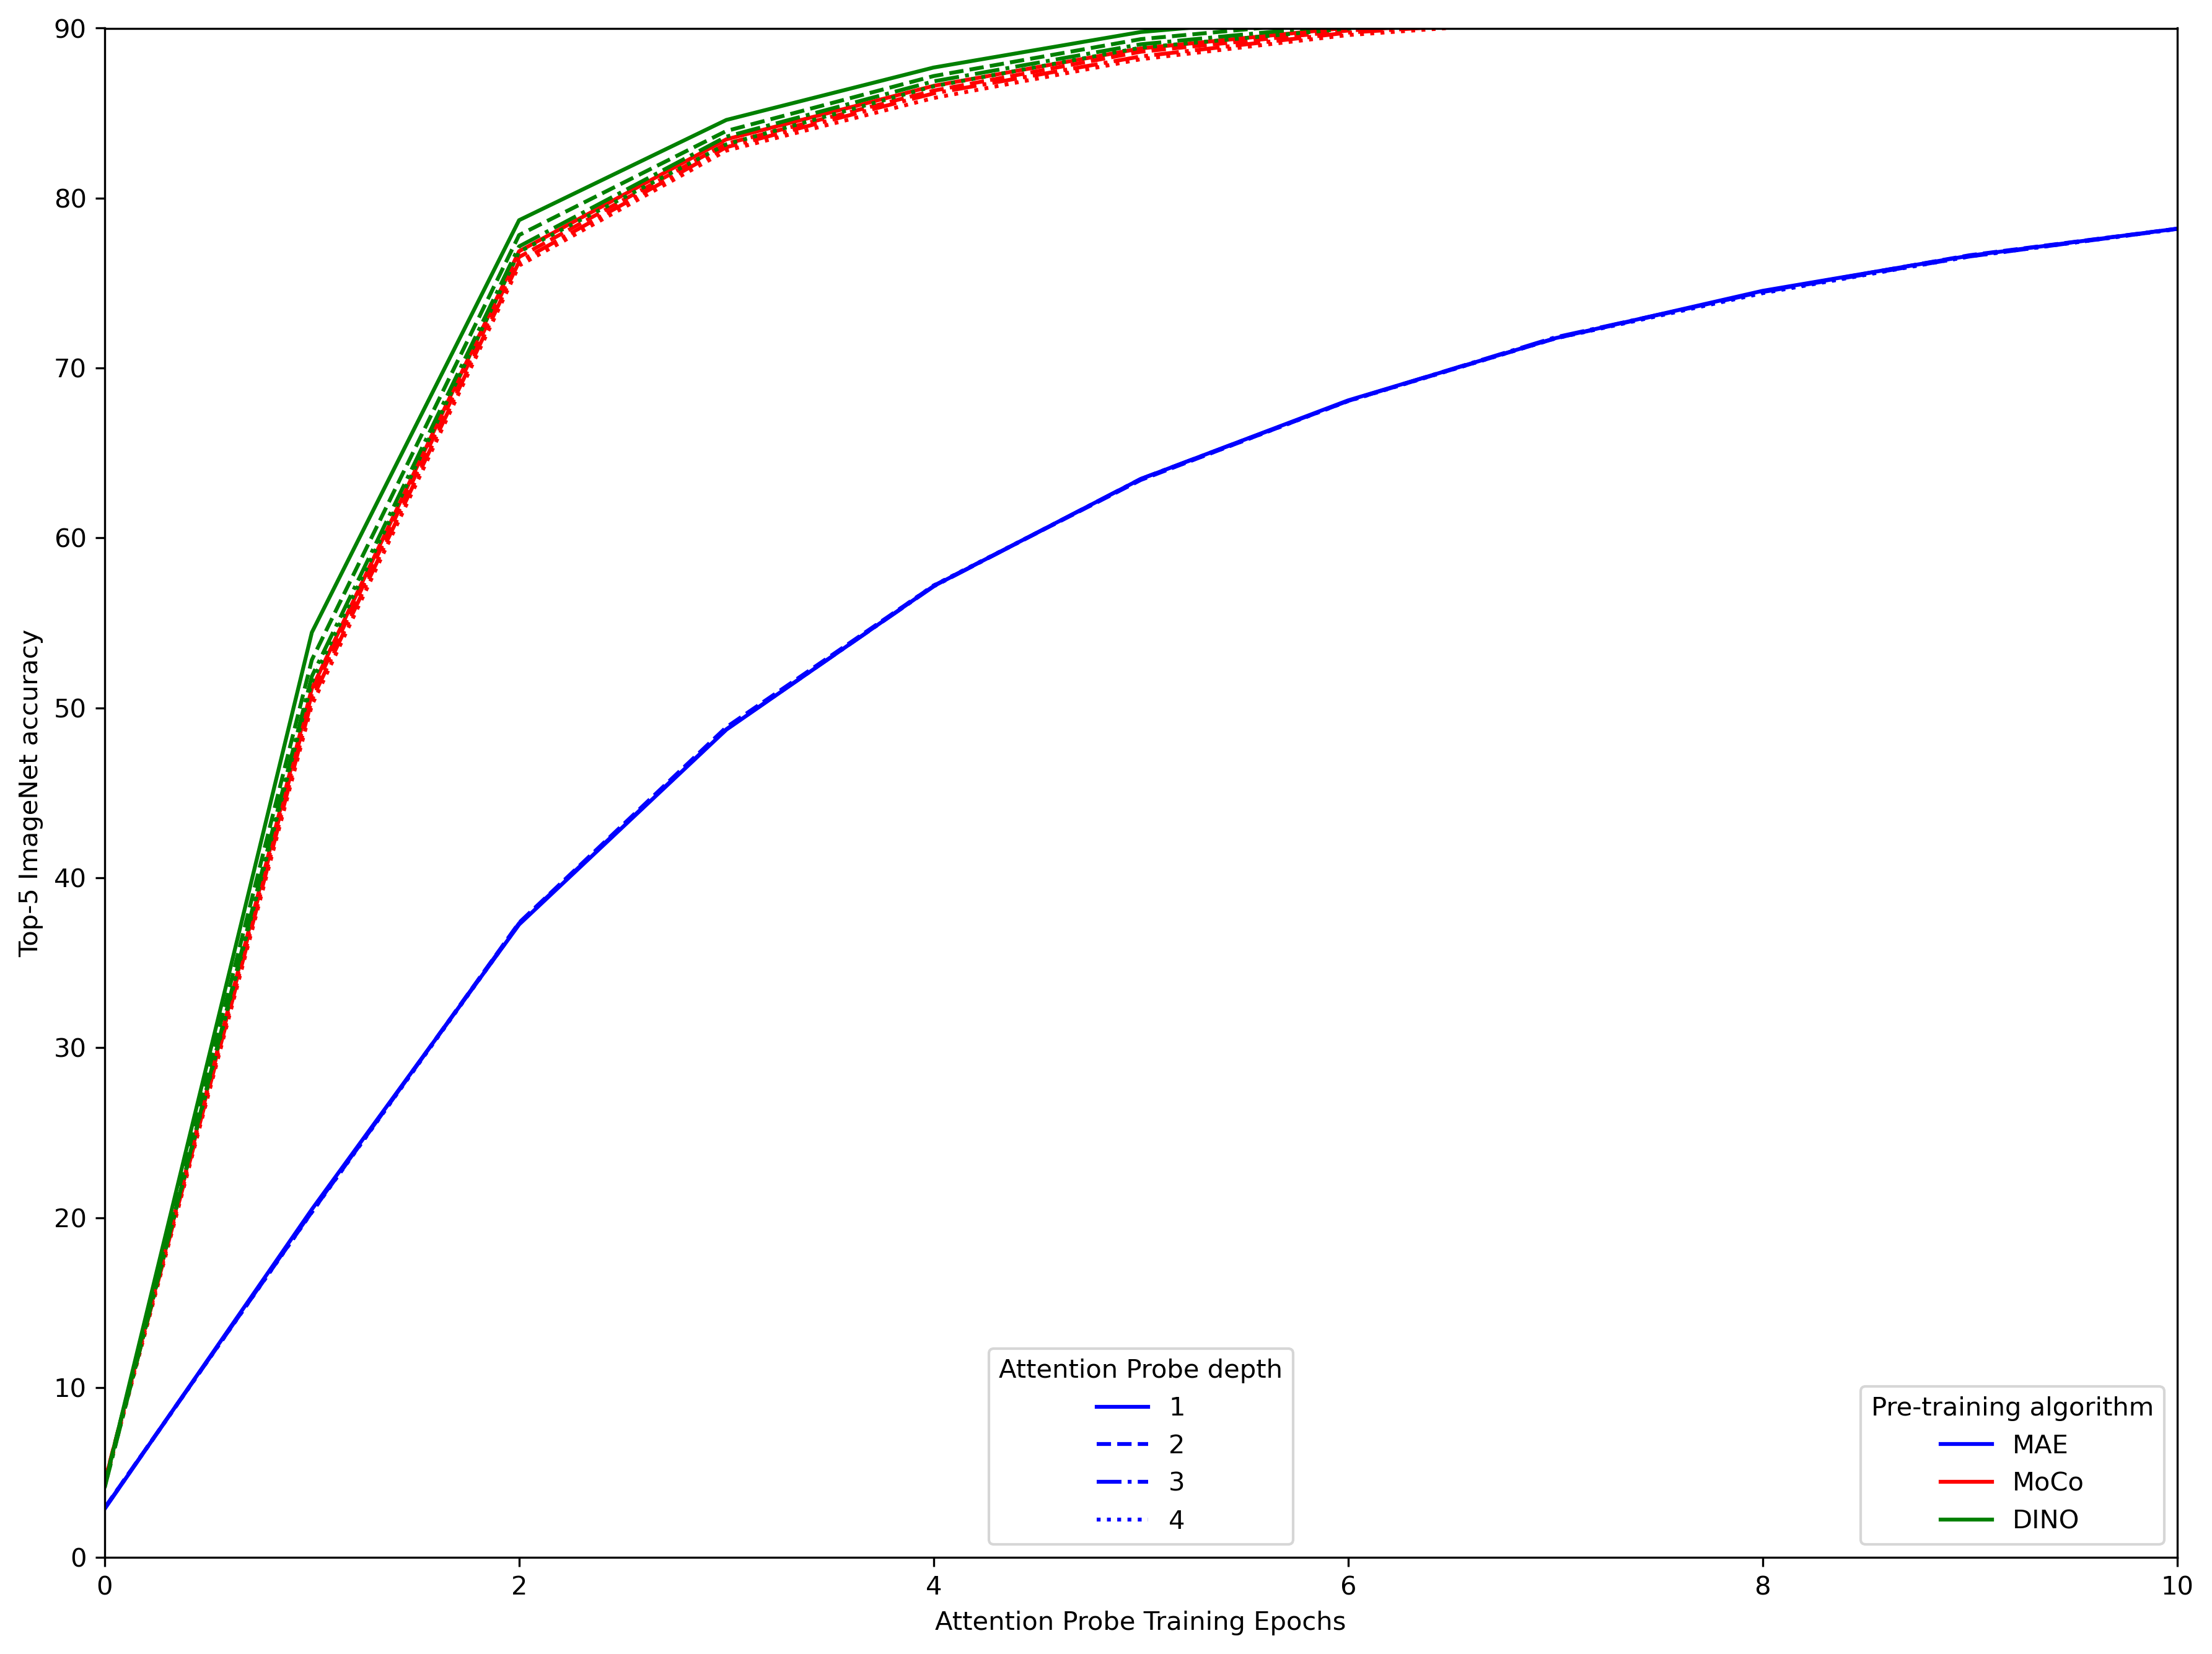

12


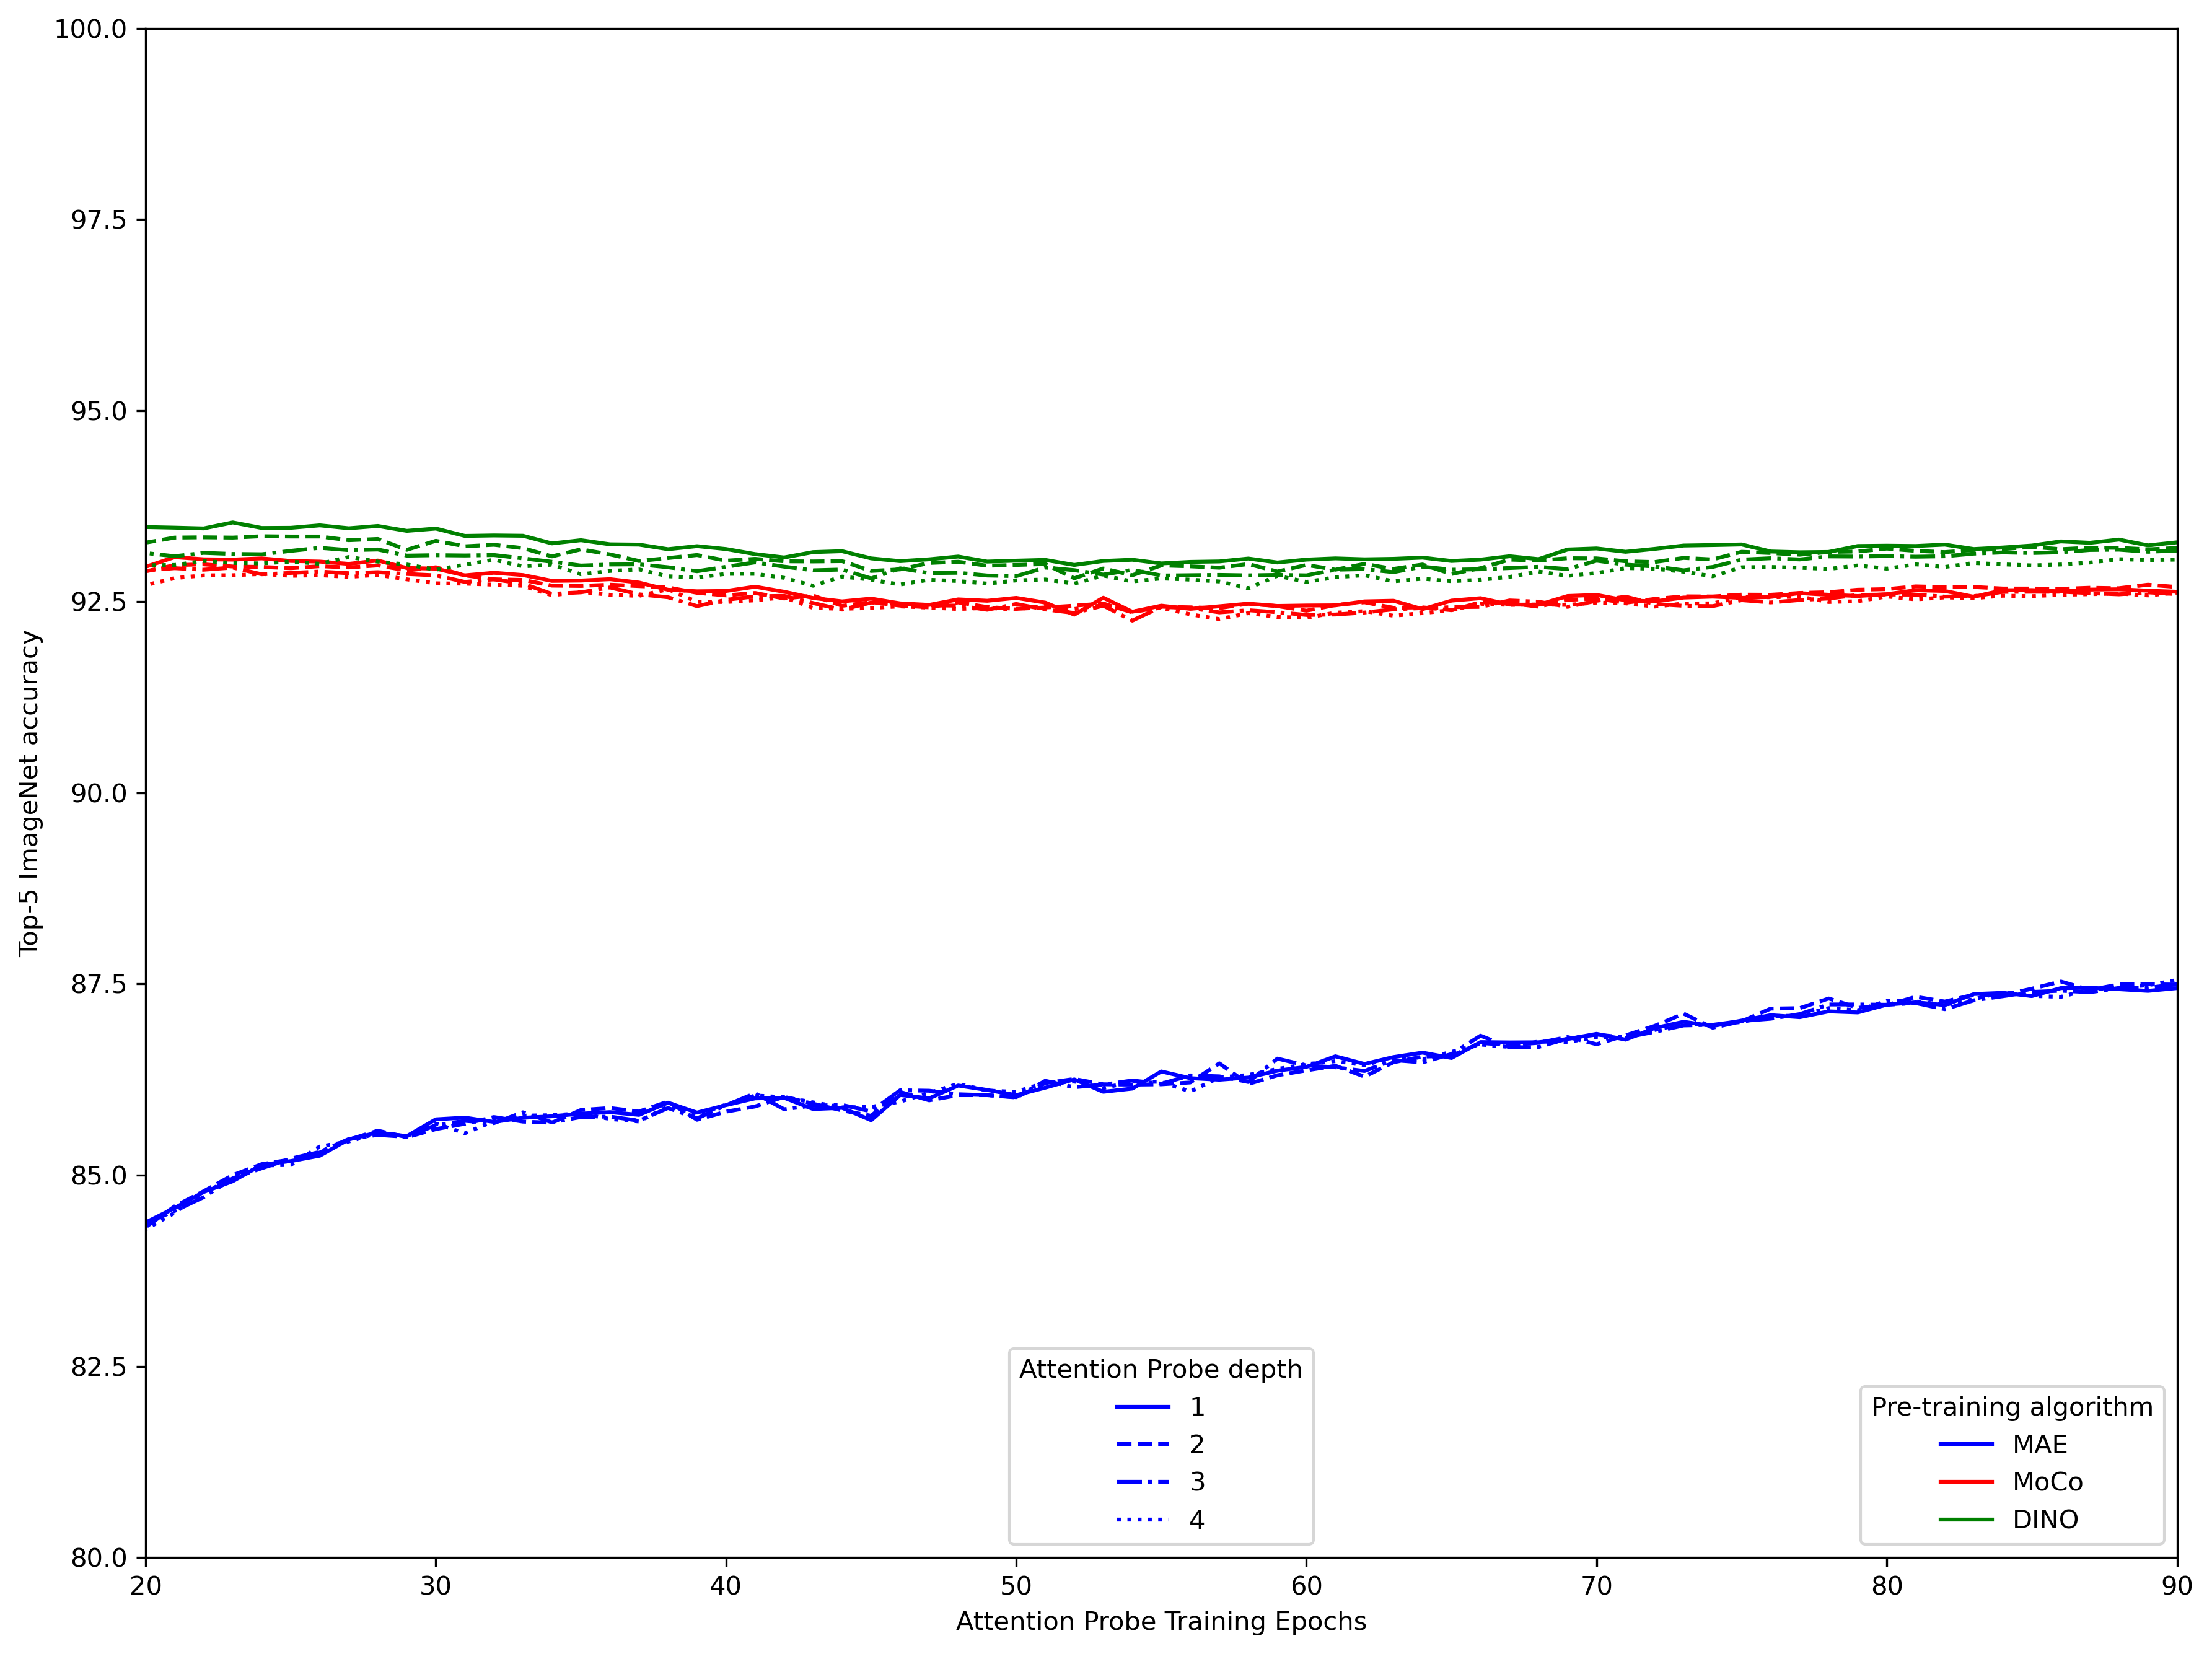

In [10]:
fig_dir = '../figures/vitprobe/'

prod = itertools.combinations(resultsa.keys(), 3)

for name1, name2, name3 in prod:
    for col in ["test_acc1", "test_acc5"]:
        for crop in [None, 'f20', 'l70']:
            full_fig_dir = fig_dir + col + '/'
            fig = dynamics_plot_single(full_fig_dir, resultsa[name1], resultsa[name2], resultsa[name3], name1, name2, name3, col=col, crop=crop)

In [11]:
for key in resultsa:
    for depth in range(1,5):
        print(key, depth)
        print(resultsa[key][depth]['test_acc1'].max(), resultsa[key][depth]['test_acc5'].max())

MAE 1
67.70400001571656 87.61400001876831
MAE 2
67.79800003044129 87.61600003723144
MAE 3
67.85600002510071 87.6240000239563
MAE 4
67.81000002281189 87.60000004547119
MoCo 1
76.14400003784179 93.08200003143311
MoCo 2
76.05800002426147 92.98800003677368
MoCo 3
76.03800001358032 92.94600004196167
MoCo 4
75.94800001922607 92.8620000366211
DINO 1
77.28400002502441 93.53600003479004
DINO 2
76.94800002975464 93.35600003738404
DINO 3
76.77200003768921 93.2040000402832
DINO 4
76.79400002441406 93.1180000289917


### Intermediate probes eval

In [119]:
results = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in results:
    for depth in range(12):
        folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/blocks.' + str(depth) +'/'

        print(folder_name)
        for root, dirs, files in os.walk(folder_name):
            if root[len(folder_name):].count(os.sep) < 2:
                for file in files:
                    if file == 'log.txt':
                        log_file = os.path.join(root, file)     
                    
        log_list = []
        print(log_file)
        if os.path.isfile(log_file):
            if 'l1_reg' in log_file:
                print('skip')
                continue 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        results[key][depth] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.0/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.0/905744/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.1/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.1/905745/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.2/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.2/905746/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.3/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.3/905747/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.4/
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.4/90574

In [120]:
for key in ['MAE', 'DINO', 'MoCo']:
        for l1_reg in [0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/all/l1_reg/' +str(l1_reg)
            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                if root[len(folder_name):].count(os.sep) < 2:
                    for file in files:
                        if file == 'log.txt':
                            log_file = os.path.join(root, file)     
                        
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)

            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            results[key]['all'] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/all/l1_reg/0/2175236/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/DINO/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/DINO/vit_base_patch16/all/l1_reg/0/2174340/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MoCo/vit_base_patch16/all/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MoCo/vit_base_patch16/all/l1_reg/0/2307289/log.txt


In [17]:
results['MAE_FT'] = {}

for key in ['MAE_FT']:
    for depth in range(12):
        for l1_reg in [0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/blocks.' + str(depth) +'/l1_reg/' + str(l1_reg)

            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                if root[len(folder_name):].count(os.sep) < 2:
                    for file in files:
                        if file == 'log.txt':
                            log_file = os.path.join(root, file)     
                        
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)
                    
            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            results[key][depth] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.0/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.0/l1_reg/0/1713241/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.1/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.1/l1_reg/0/1713243/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.2/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.2/l1_reg/0/1713245/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.3/l1_reg/0
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.3/l1_reg/0/1713247/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE_FT/vit_base_patch16/blocks.4/

In [8]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    style = ['solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted']
    colors = ['b', 'r', 'g']
    cc = itertools.cycle(colors)
    
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, ls=style[i-1], color=c, label=name1)
        
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df2[i], ax = ax, ls=style[i-1], color=c, label=name2)
        
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df3[i], ax = ax, ls=style[i-1], color=c, label=name3)
        
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    #plt.xlim([20, 90])
    #plt.ylim([60, 80])
    
    ax.set_xlabel("Fine-tuning Epochs")
    ax.set_ylabel("Top-5 ImageNet accuracy")
    
    print(len(ax.lines))
    #ax.legend(title='Pre-training algorithm', loc='lower center')#, labels=[name1, name2, name3])
    legend1 = plt.legend([ax.lines[0], ax.lines[12], ax.lines[24]], [name1, name2, name3], title='Pre-training algorithm', loc=4)
    others = [line for line in ax.lines if line not in [ax.lines[0], ax.lines[12], ax.lines[23]]]
    legends = ['block-'+str(i) for i in range(12)]
    plt.legend(others, legends, title='Intermediate features depth', loc=8)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'-top1-cropped.png')

    return fig

In [9]:
def dynamics_plot_individual(fig_dir, df1, name1, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    colors = sns.color_palette("viridis", n_colors=12)
    colors.reverse()
    
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, color=colors[i], label='block.11 + block.'+str(i))

    #sns.lineplot(x='epoch', y=col, data = resultsp[name1][1], ax = ax, color='r', label='block.11 only')

    
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    plt.xlim([20, 100])
    plt.ylim([75, 85])
    
    ax.set_xlabel("Linear Probe Training Epochs")
    ax.set_ylabel("Linear Probe Top-1 ImageNet accuracy")
    ax.set_title(name1+' intermediate features marginal utility')
    
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-top1-cropped.png')

    return fig

In [121]:
import itertools

In [122]:
for name in results:
    print(name, 'final', resultsp[name][1].test_acc1.max())
    for k in results[name]:
        print(name, k, results[name][k].test_acc1.max(), results[name][k].test_acc1.max() - resultsp[name][1].test_acc1.max())

MAE final 67.69600000991821
MAE 0 67.38400001281738 -0.31199999710082693
MAE 1 67.18200000473023 -0.514000005187981
MAE 2 67.24400002059936 -0.45199998931884977
MAE 3 67.48600002059936 -0.20999998931884534
MAE 4 67.84600001846313 0.15000000854492157
MAE 5 67.89000001861572 0.19400000869751466
MAE 6 68.24400003753662 0.5480000276184143
MAE 7 68.5820000213623 0.8860000114440965
MAE 8 69.22600001113892 1.5300000012207136
MAE 9 69.44200001922607 1.7460000093078634
MAE 10 69.33600001922608 1.6400000093078688
MAE 11 67.47400001281738 -0.22199999710082352
MAE all 69.97000001663208 2.2740000067138766
MoCo final 76.24200002227784
MoCo 0 76.01600000854492 -0.22600001373291434
MoCo 1 75.87600001159667 -0.3660000106811623
MoCo 2 75.9380000326538 -0.30399998962403174
MoCo 3 75.88600001678466 -0.356000005493172
MoCo 4 75.78199998687744 -0.46000003540039813
MoCo 5 75.94000004882813 -0.3019999734497105
MoCo 6 76.14200002471924 -0.0999999975585979
MoCo 7 76.14800002716065 -0.09399999511718704
MoCo 8 76

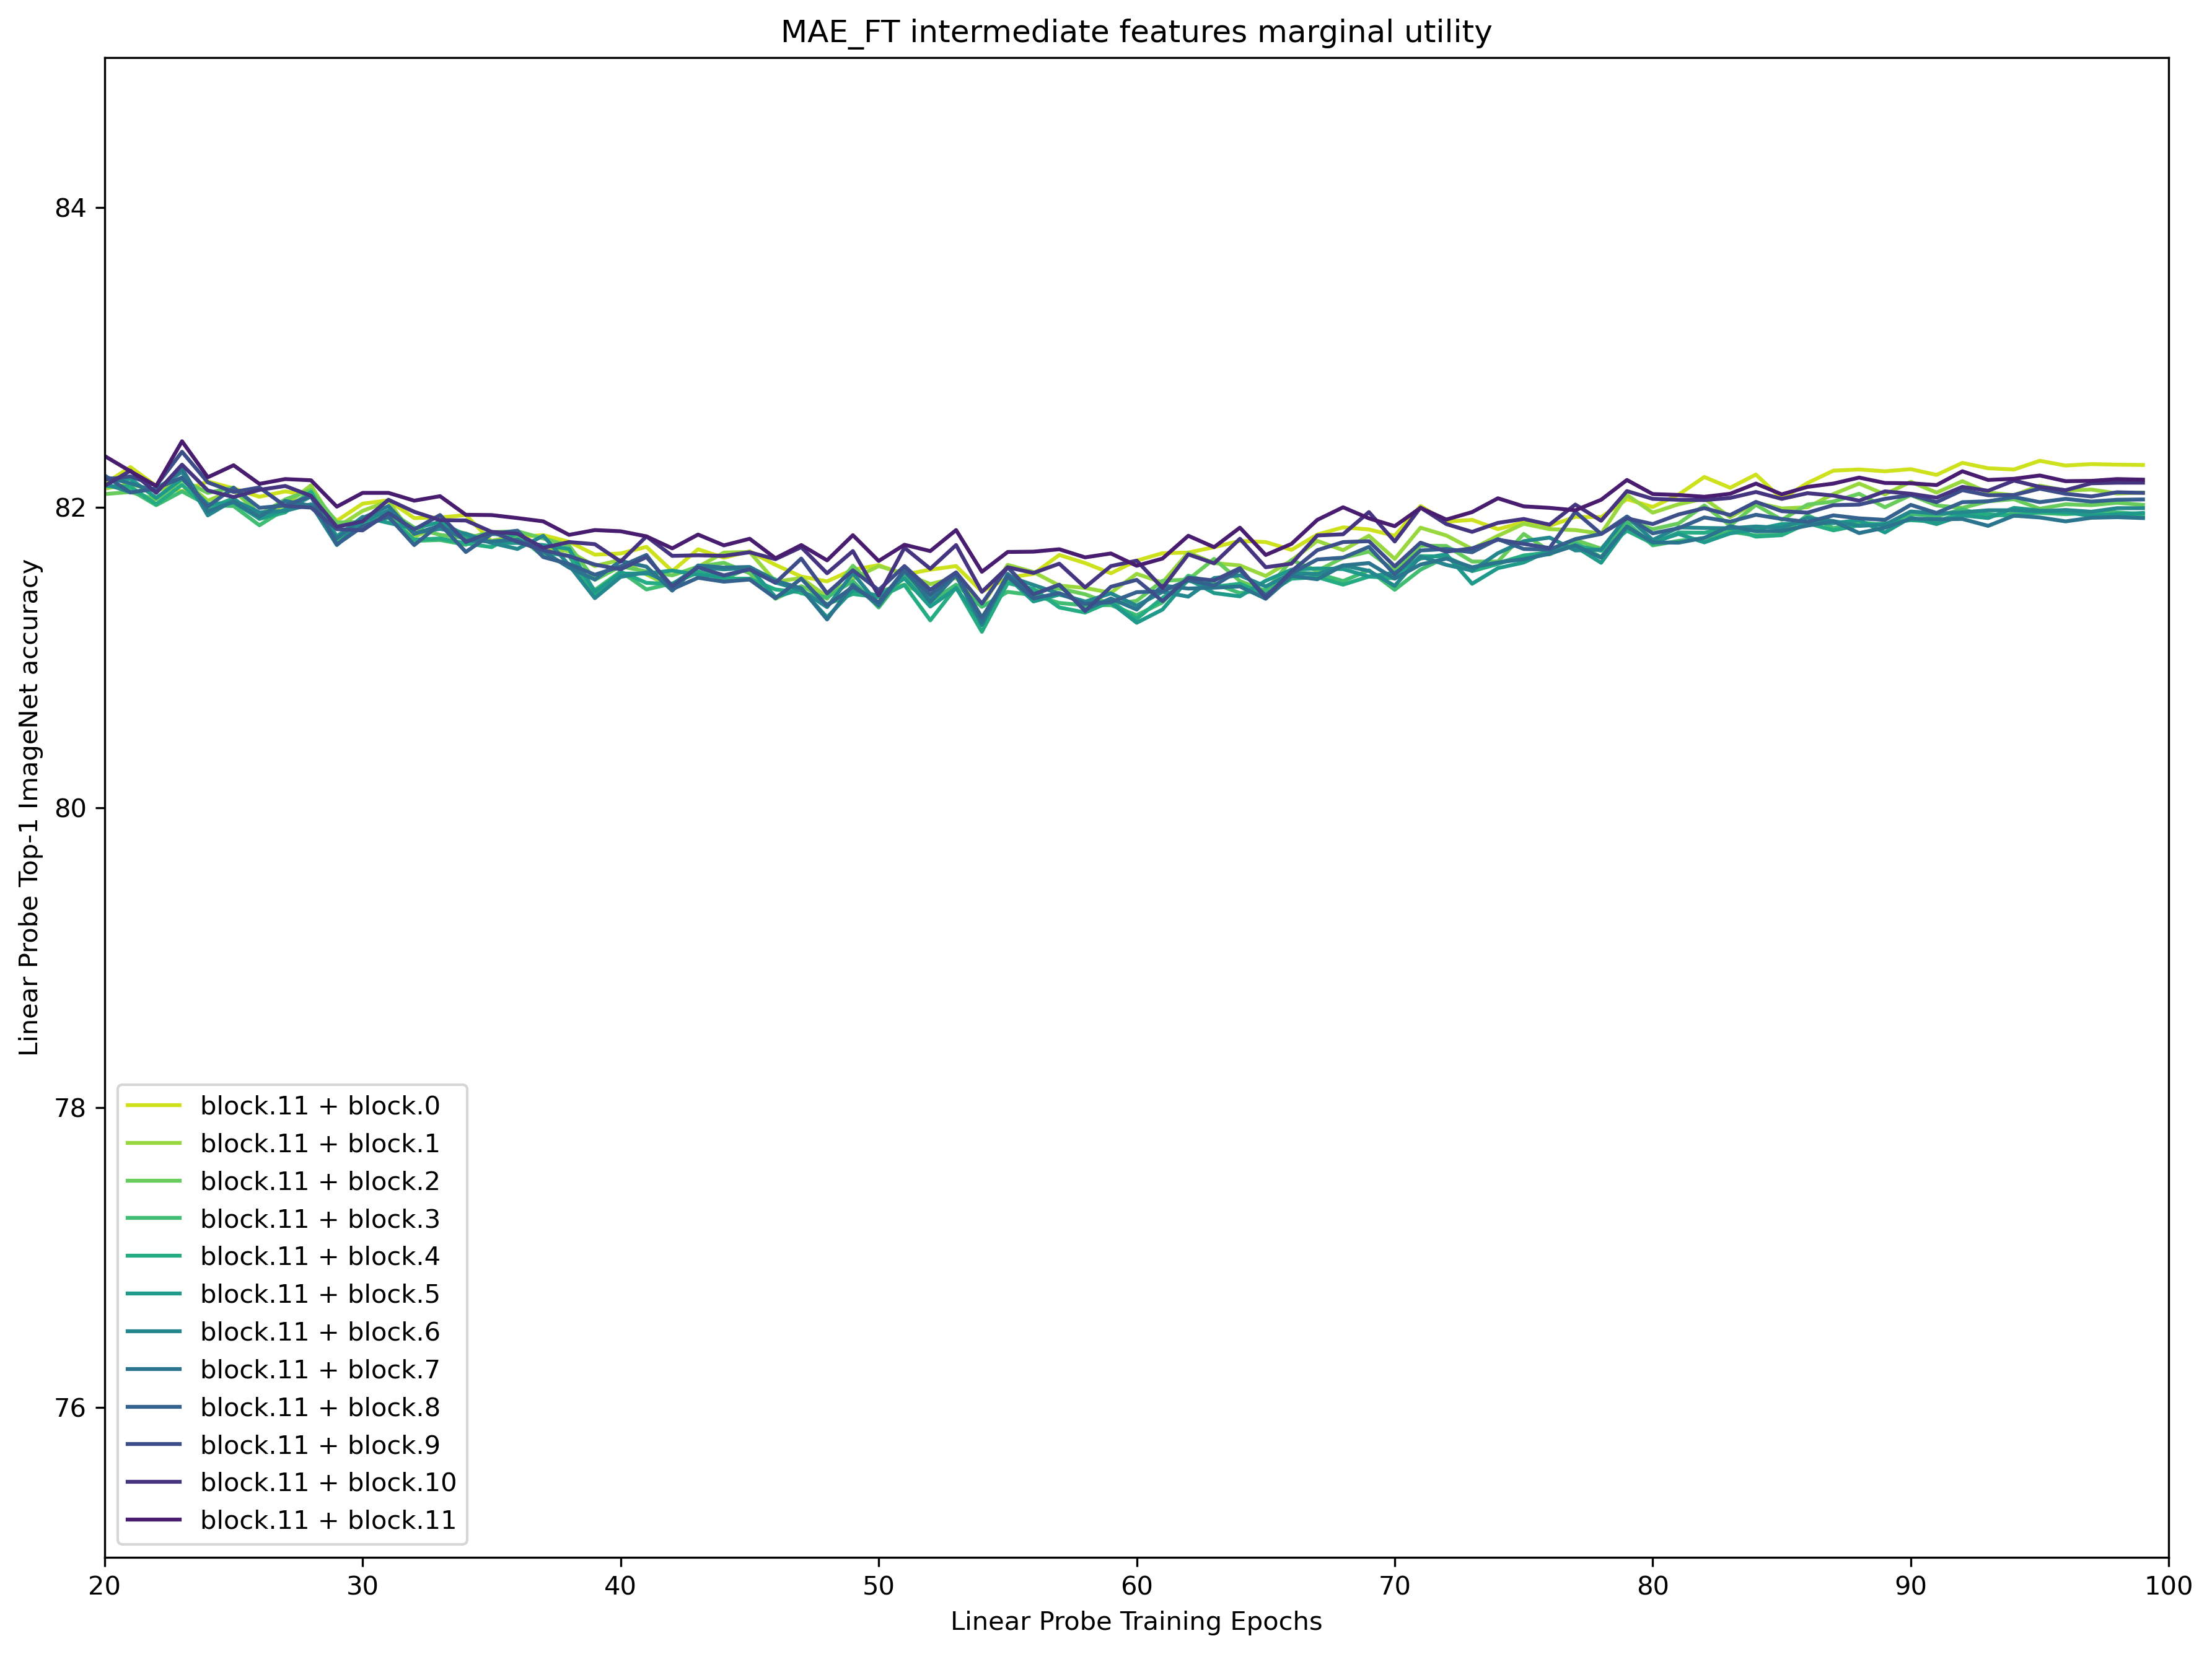

In [30]:
fig_dir = '../figures/intermediateprobe/'

prod = itertools.combinations(results.keys(), 3)

for name1 in ["MAE_FT"]: #results.keys():
    for col in ["test_acc1"]:
        full_fig_dir = fig_dir + col + '/'
        fig = dynamics_plot_individual(full_fig_dir, results[name1], name1, col=col)

In [17]:
for key in results:
    for depth in range(1,12):
        print(key, depth)
        print(results[key][depth]['test_acc1'].max(), results[key][depth]['test_acc5'].max())

MAE 1
67.18200000473023 87.08600004760743
MAE 2
67.24400002059936 87.11800003173828
MAE 3
67.48600002059936 87.37200002624512
MAE 4
67.84600001846313 87.46400002105713
MAE 5
67.89000001861572 87.56200001556397
MAE 6
68.24400003753662 87.78800003967285
MAE 7
68.5820000213623 88.00600001556397
MAE 8
69.22600001113892 88.36600001556397
MAE 9
69.44200001922607 88.68200001312256
MAE 10
69.33600001922608 88.40400004302978
MAE 11
67.47400001281738 87.32200001831055
MoCo 1
75.87600001159667 93.08000000976563
MoCo 2
75.9380000326538 93.06800004211426
MoCo 3
75.88600001678466 93.06200005279541
MoCo 4
75.78199998687744 93.0580000366211
MoCo 5
75.94000004882813 93.106000050354
MoCo 6
76.14200002471924 93.11600004760743
MoCo 7
76.14800002716065 93.0960000314331
MoCo 8
76.23400000061035 93.13400002624512
MoCo 9
76.26400002441406 93.142000055542
MoCo 10
76.26800001098633 93.13400003936768
MoCo 11
76.13800001403808 93.16800003417968
DINO 1
77.46600001922607 93.68600003723145
DINO 2
77.5060000112915 93

In [128]:
df= {}
for key in results:
    df[key] = {}
    for inter in results[key]:
        print(key, inter)
        df[key][inter] = {}
        print(results[key][inter]['test_acc1'].max(), results[key][inter]['test_acc5'].max())
        df[key][inter] = results[key][inter]['test_acc1'].max()

MAE 0
67.38400001281738 87.17600001556397
MAE 1
67.18200000473023 87.08600004760743
MAE 2
67.24400002059936 87.11800003173828
MAE 3
67.48600002059936 87.37200002624512
MAE 4
67.84600001846313 87.46400002105713
MAE 5
67.89000001861572 87.56200001556397
MAE 6
68.24400003753662 87.78800003967285
MAE 7
68.5820000213623 88.00600001556397
MAE 8
69.22600001113892 88.36600001556397
MAE 9
69.44200001922607 88.68200001312256
MAE 10
69.33600001922608 88.40400004302978
MAE 11
67.47400001281738 87.32200001831055
MAE all
69.97000001663208 88.96800001861573
MoCo 0
76.01600000854492 93.1100000125122
MoCo 1
75.87600001159667 93.08000000976563
MoCo 2
75.9380000326538 93.06800004211426
MoCo 3
75.88600001678466 93.06200005279541
MoCo 4
75.78199998687744 93.0580000366211
MoCo 5
75.94000004882813 93.106000050354
MoCo 6
76.14200002471924 93.11600004760743
MoCo 7
76.14800002716065 93.0960000314331
MoCo 8
76.23400000061035 93.13400002624512
MoCo 9
76.26400002441406 93.142000055542
MoCo 10
76.26800001098633 93.

In [129]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Intermediate Feature'}, inplace=True)
df = df.melt(id_vars=['Intermediate Feature'], value_name='Top-1', var_name='Model')

In [130]:
fig_dir = '../figures/ICML/'

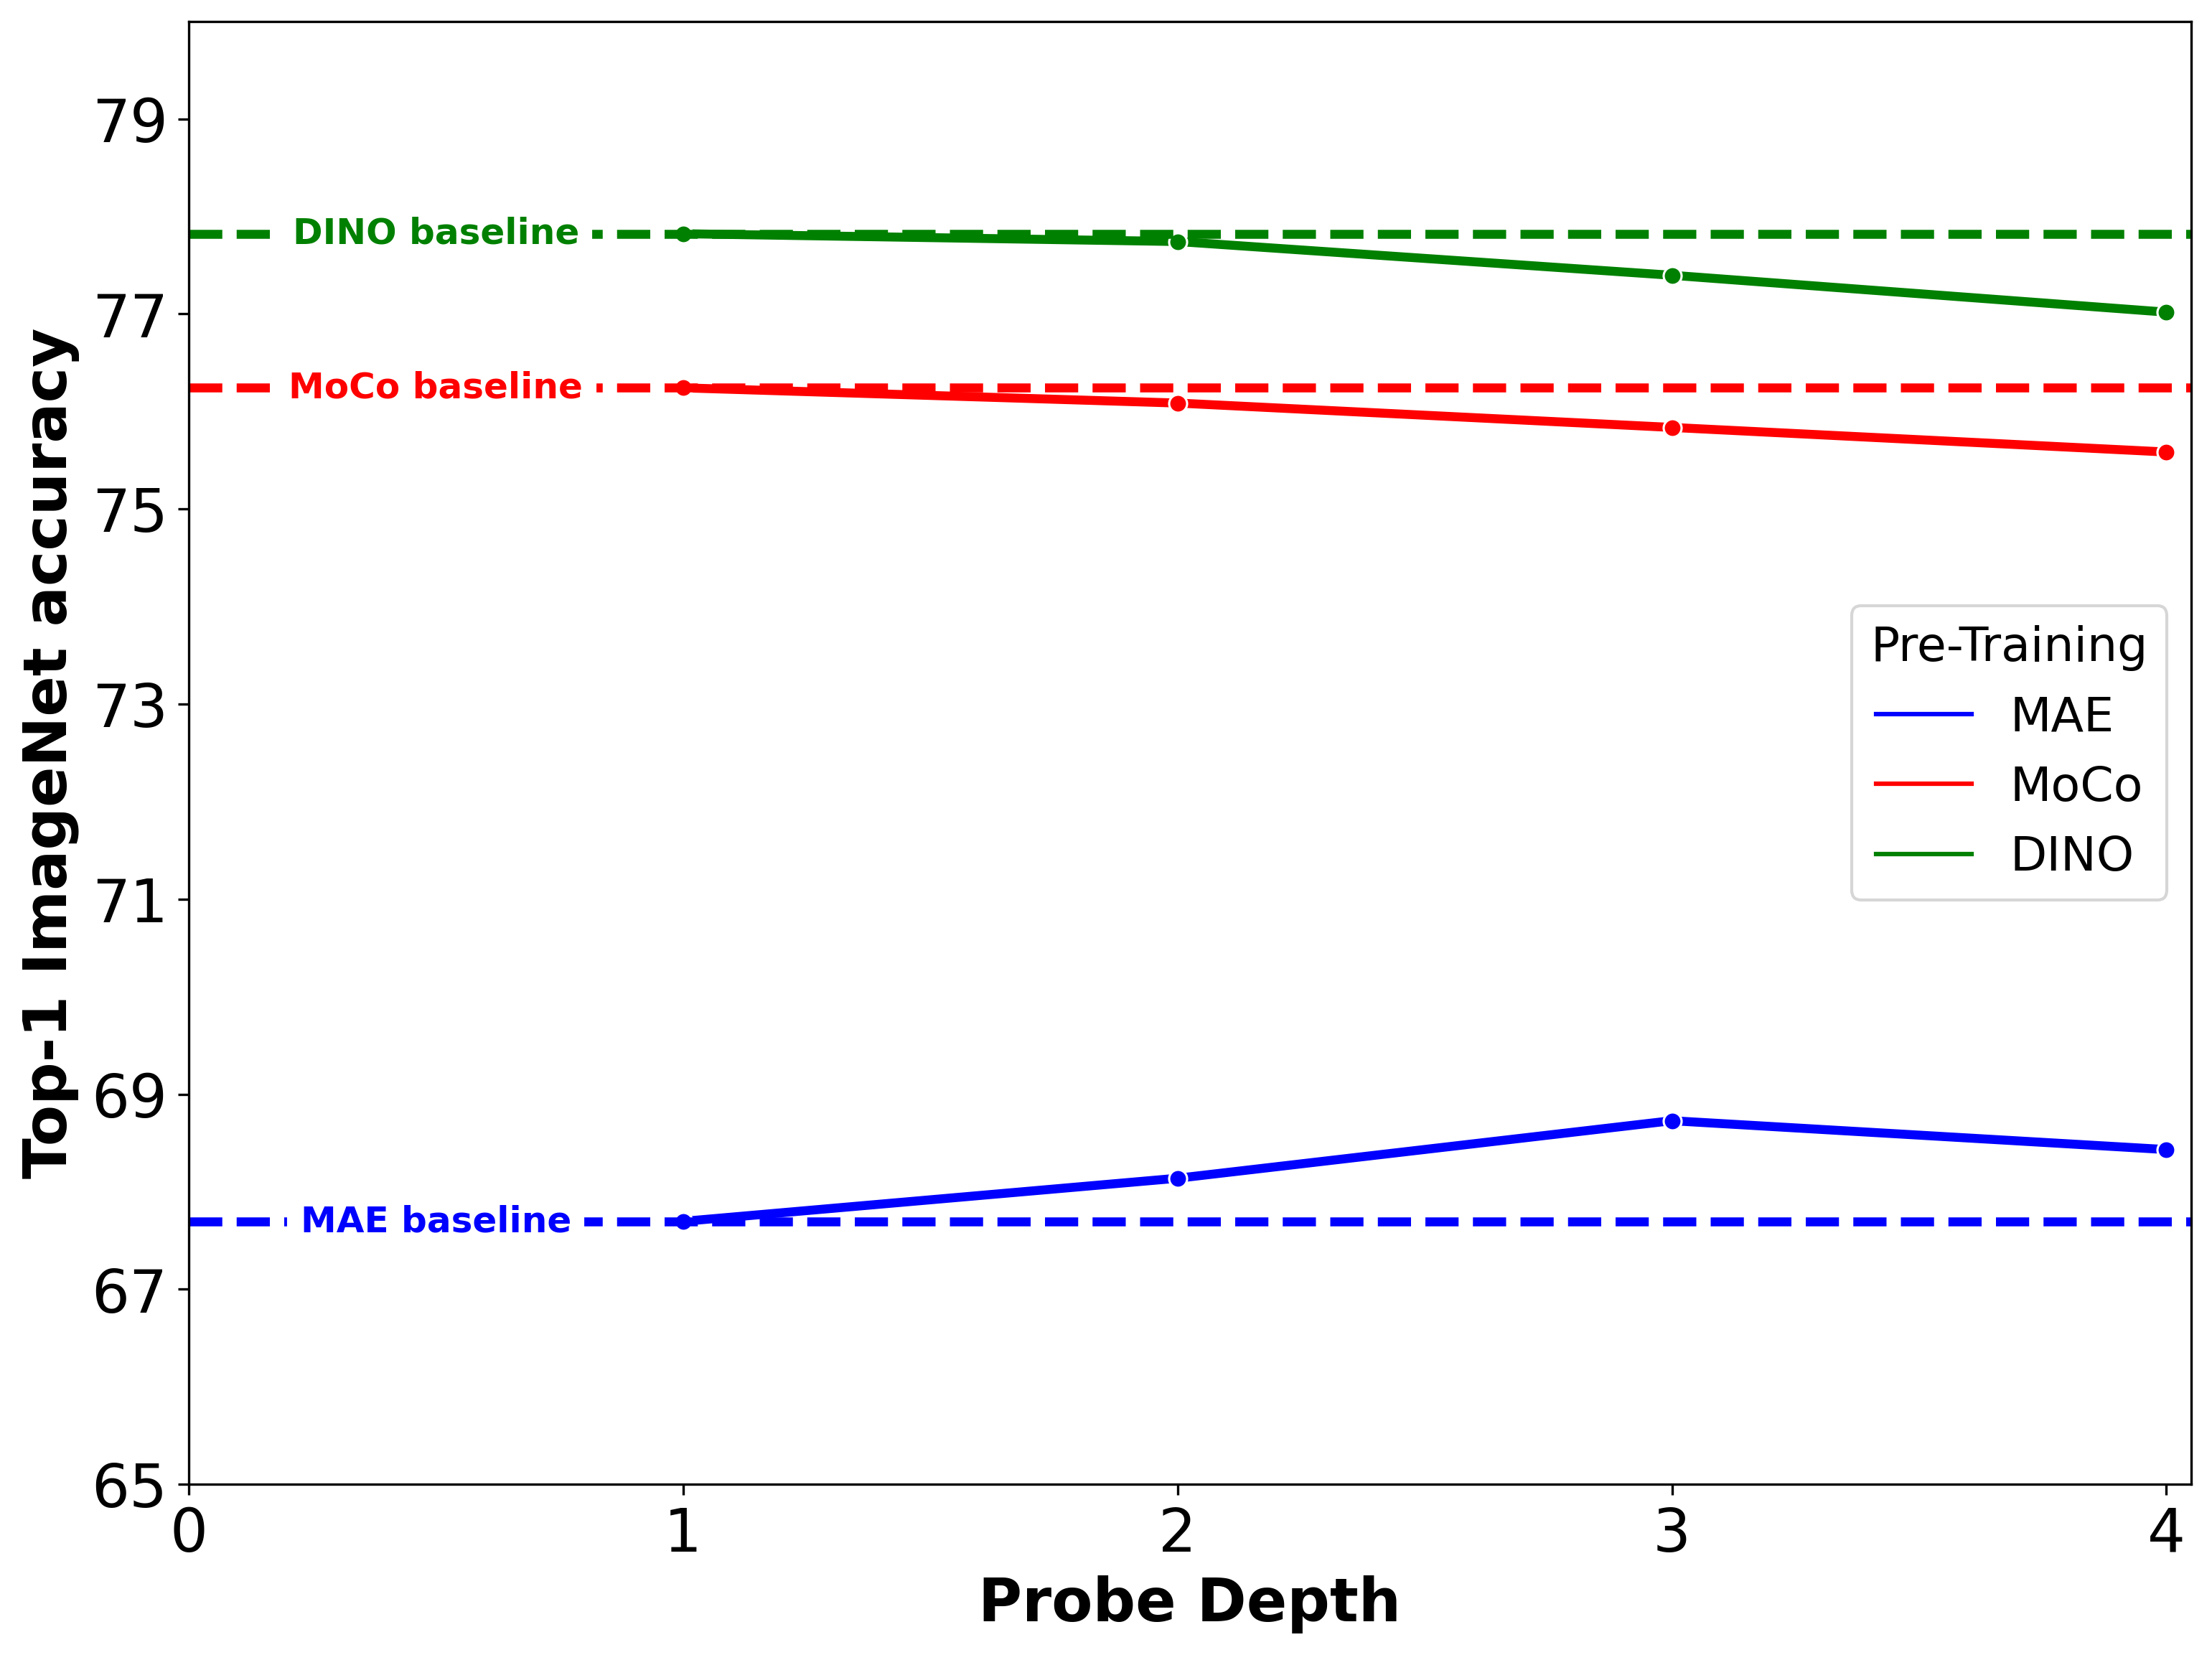

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

sns.lineplot(data=df, x='Probe Depth', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3)
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MAE') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'MoCo') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.5, (df[(df['Model'] == 'DINO') & (df['Probe Depth'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')

ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 ImageNet accuracy", fontweight="bold", fontsize = 20)

plt.xlim([0, 4.05])
plt.ylim([65, 80])

ax.set_xticks(np.arange(0, 5, 1), visible=True)
ax.set_yticks(np.arange(65, 80, 2), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(65, 80, 2)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16})
plt.setp(legend.get_title(),fontsize=16)

fig.savefig(fig_dir + 'deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Intermediate probes eval with L1 reg

In [19]:
resultsl1 = {'MAE': {}}

for key in resultsl1:
    for depth in range(9, 10):
        for l1_reg in [5e-4, 1e-3, 1e-2, 5e-2, 0.1, 0.5, 1.0]:
            folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/" + key + '/vit_base_patch16/blocks.' + str(depth) +'/l1_reg/' + str(l1_reg)

            print(folder_name)
            for root, dirs, files in os.walk(folder_name):
                for file in files:
                    if file == 'log.txt':
                        log_file = os.path.join(root, file)     
                    
            log_list = []
            print(log_file)
            if os.path.isfile(log_file):
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)
                    
            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            resultsl1[key][l1_reg] = df

/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.0005
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.0005/1452364/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.001
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.001/1452365/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.01
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.01/1452368/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.05
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks.9/l1_reg/0.05/1452367/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/multi_linprob/logs/MAE/vit_base_patch16/blocks

In [20]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    style = ['solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted']
    colors = ['b', 'r', 'g']
    cc = itertools.cycle(colors)
    
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, ls=style[i-1], color=c, label=name1)
        
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df2[i], ax = ax, ls=style[i-1], color=c, label=name2)
        
    c = next(cc)
    for i in range(12):
        sns.lineplot(x='epoch', y=col, data = df3[i], ax = ax, ls=style[i-1], color=c, label=name3)
        
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    #plt.xlim([20, 90])
    #plt.ylim([60, 80])
    
    ax.set_xlabel("Fine-tuning Epochs")
    ax.set_ylabel("Top-5 ImageNet accuracy")
    
    print(len(ax.lines))
    #ax.legend(title='Pre-training algorithm', loc='lower center')#, labels=[name1, name2, name3])
    legend1 = plt.legend([ax.lines[0], ax.lines[12], ax.lines[24]], [name1, name2, name3], title='Pre-training algorithm', loc=4)
    others = [line for line in ax.lines if line not in [ax.lines[0], ax.lines[12], ax.lines[23]]]
    legends = ['block-'+str(i) for i in range(12)]
    plt.legend(others, legends, title='Intermediate features depth', loc=8)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'-top1-cropped.png')

    return fig

In [21]:
def dynamics_plot_individuall1(fig_dir, df1, name1, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    colors = sns.color_palette("viridis", n_colors=12)
    colors.reverse()
    
    for index, i in enumerate([5e-4, 1e-3, 1e-2, 5e-2, 0.1, 0.5, 1.0]):
        sns.lineplot(x='epoch', y=col, data = df1[i], ax = ax, color=colors[index], label='L1 reg strength=' +str(i))

    sns.lineplot(x='epoch', y=col, data = results[name1][9], ax = ax, color='r', label='No L1 reg')

    
    '''
    axins = inset_axes(ax,  "25%", "40%" ,loc="upper right", borderpad=2.5)
    sns.lineplot(x='epoch', y=col, data = df1, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df2, ax = axins)
    sns.lineplot(x='epoch', y=col, data = df3, ax = axins)
    axins.set_xlim([0,8])
    axins.set_xlabel("")
    axins.set_ylabel("")
    '''

    plt.xlim([0, 90])
    #plt.ylim([60, 80])
    
    ax.set_xlabel("Linear Probe Training Epochs")
    ax.set_ylabel("Top-1 ImageNet accuracy")
    ax.set_title(name1+' block11+block9 intermediate features marginal utility')
    
    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+name1+'-top1.png')

    return fig

In [22]:
import itertools

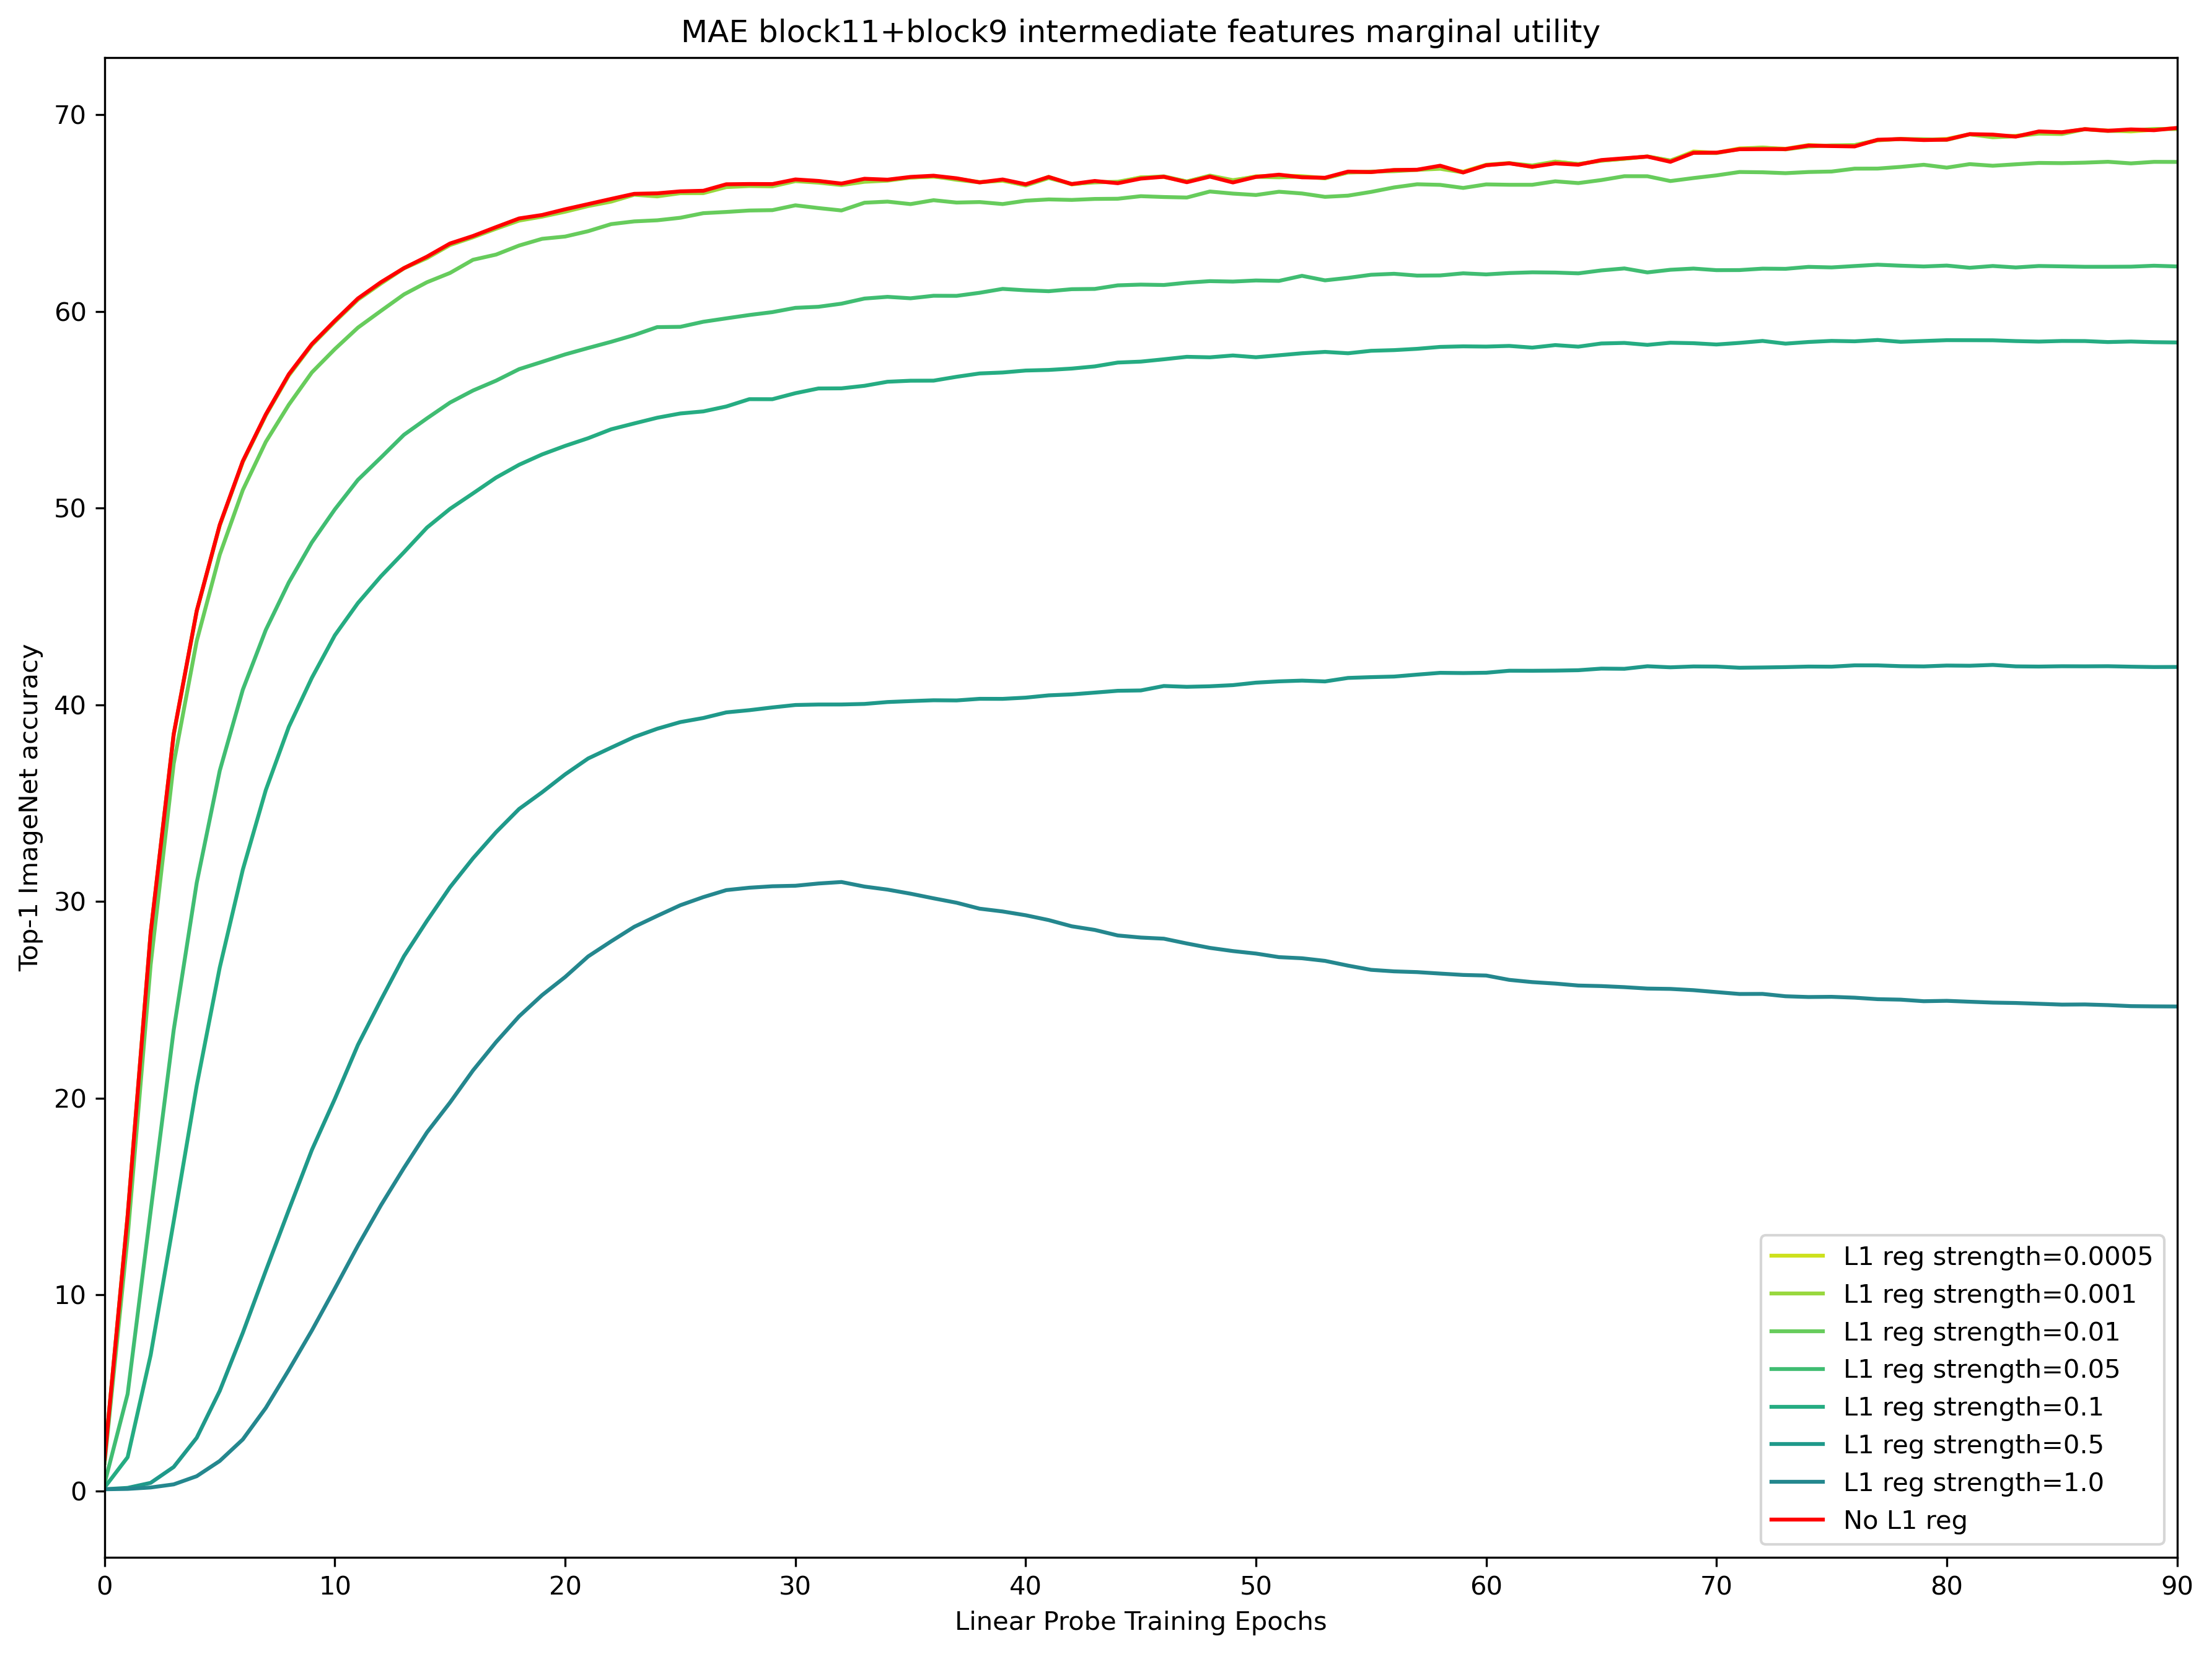

In [24]:
fig_dir = '../figures/intermediateprobe-l1/'

prod = itertools.combinations(results.keys(), 3)

for name1 in resultsl1.keys():
    for col in ["test_acc1"]:
        full_fig_dir = fig_dir + col + '/'
        fig = dynamics_plot_individuall1(full_fig_dir, resultsl1[name1], name1, col=col)